# __Image Processing and Analysis - 2nd Set of Exercises__
__Name:__ Konstantinos Giatras

__Student ID:__ 7115152300005

__Professor:__ Vassilis Katsouros

__Academic Year:__ 2023-2024

MSc Data Science & Information Technologies, Bioinformatics - Biomedical Data Science Specialization

***

In this assignment, we use the dataset in https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia and develop an intelligent system do detect pneumonia in chest X-ray images. An overview of this notebook is as follows:

1. Exploring the data and defining appropriate classes
2. Visualizing data and employing appropriate preprocessing to X-ray images
3. Developing the detection algorithms
    1. Using features and classical machine learning techniques
    2. Using a neural network architecture (we may investigate various architectures or use an existing one)
4. Presenting the results of the used algorithms (evaluation metrics, comparison of algorithms)

# <ins>Data Exploration and Class Definition</ins>

First, we need to import the necessary libraries and load the dataset.

In [25]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
import cv2
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix, roc_auc_score, matthews_corrcoef, precision_score, balanced_accuracy_score, f1_score, recall_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import optuna
import skimage.feature as skif
from skimage import measure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchsummary import summary
import copy
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# Defining the data directory
data_dir = Path("chest_xray")

# Listing the directories in the data directory
print(f"Contents of {data_dir}: {os.listdir(data_dir)}")

Contents of chest_xray: ['test', 'val', 'train']


We can see that the main directory contains three subdirectories, namely "test", "val" and "train". Now, let's understand the structure of the dataset by exploring the contents of these subdirectories. This will help us identify the classes and the organization of images.

In [3]:
# Defining the subdirectories for the training, test and validation sets
train_dir = data_dir / "train"
test_dir = data_dir / "test"
val_dir = data_dir / "val"

# Listing the classes in the training directory
train_classes = os.listdir(train_dir)
print(f"Classes in the training directory: {train_classes}")

# Listing the number of images in each class in the training directory
for class_name in train_classes:
    class_dir = train_dir / class_name
    num_images = len(os.listdir(class_dir))
    print(f"Number of images in {class_name}: {num_images}")
    
# Listing the classes in the test directory
test_classes = os.listdir(test_dir)
print(f"Classes in the test directory: {test_classes}")

# Listing the number of images in each class in the test directory
for class_name in test_classes:
    class_dir = test_dir / class_name
    num_images = len(os.listdir(class_dir))
    print(f"Number of images in {class_name}: {num_images}")

# Listing the classes in the validation directory
val_classes = os.listdir(val_dir)
print(f"Classes in the validation directory: {val_classes}")

# Listing the number of images in each class in the validation directory
for class_name in val_classes:
    class_dir = val_dir / class_name
    num_images = len(os.listdir(class_dir))
    print(f"Number of images in {class_name}: {num_images}")

Classes in the training directory: ['PNEUMONIA', 'NORMAL']
Number of images in PNEUMONIA: 3875
Number of images in NORMAL: 1341
Classes in the test directory: ['PNEUMONIA', 'NORMAL']
Number of images in PNEUMONIA: 390
Number of images in NORMAL: 234
Classes in the validation directory: ['PNEUMONIA', 'NORMAL']
Number of images in PNEUMONIA: 8
Number of images in NORMAL: 8


We can see that each of the "test", "val" and "train" folders contains two subfolders for different sets of images, specifically "PNEUMONIA" and "NORMAL". The dataset consists of a total of $5,863$ X-Ray images in JPEG format. We will now create a separate dataframe for each of the "test", "val" and "train" datasets and apply the appropriate class labels ($0$ for 'NORMAL', $1$ for 'PNEUMONIA') to each image.

In [4]:
# Defining class labels
class_labels = {'NORMAL': 0, 'PNEUMONIA': 1}

# Function to create DataFrame for a given directory (train, test, val)
def create_dataframe(directory):
    data = []
    # Iterating over each class in the directory (NORMAL, PNEUMONIA)
    for class_name in os.listdir(directory):
        class_dir = directory / class_name
        # Iterating over each image in the class directory
        for img_name in os.listdir(class_dir):
            img_path = class_dir / img_name
            data.append([img_path, class_labels[class_name]]) # appending the image path and class label
    return pd.DataFrame(data, columns=['image_path', 'label'])

# Creating DataFrames for train, test, and validation sets
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)
val_df = create_dataframe(val_dir)

# Displaying the first few rows of each DataFrame
print("Training DataFrame:")
print(train_df.head())

print("\nTesting DataFrame:")
print(test_df.head())

print("\nValidation DataFrame:")
print(val_df.head())

Training DataFrame:
                                          image_path  label
0  chest_xray/train/PNEUMONIA/person108_virus_200...      1
1  chest_xray/train/PNEUMONIA/person669_bacteria_...      1
2  chest_xray/train/PNEUMONIA/person155_virus_307...      1
3  chest_xray/train/PNEUMONIA/person1369_virus_23...      1
4  chest_xray/train/PNEUMONIA/person508_virus_102...      1

Testing DataFrame:
                                          image_path  label
0  chest_xray/test/PNEUMONIA/person1653_virus_285...      1
1  chest_xray/test/PNEUMONIA/person1642_virus_284...      1
2  chest_xray/test/PNEUMONIA/person87_bacteria_43...      1
3  chest_xray/test/PNEUMONIA/person1643_virus_284...      1
4  chest_xray/test/PNEUMONIA/person1680_virus_289...      1

Validation DataFrame:
                                          image_path  label
0  chest_xray/val/PNEUMONIA/person1947_bacteria_4...      1
1  chest_xray/val/PNEUMONIA/person1954_bacteria_4...      1
2  chest_xray/val/PNEUMONIA/person194

## Validation Set Size

There is an issue that needs to be addressed. We have an extremely small validation set consisting of only images ($8$ per class), which is problematic because the performance metrics (accuracy, precision, recall, etc.) may not be reliable and can vary significantly with small changes in the model and there is also an increased risk of overfitting, because the model might perform well on these few samples but fail to generalize to new, unseen data.

To address the small validation set issue, we can merge the training and validation sets and then perform a stratified split to ensure that the new validation set has $20\%$ of the combined training size with the same label distribution.

In [5]:
# Combining train and validation DataFrames
combined_df = pd.concat([train_df, val_df], axis=0)

# Separating features and labels
X = combined_df.drop('label', axis=1)
y = combined_df['label']

# Displaying the shape of the combined DataFrame
print(f"Total combined dataset shape: {combined_df.shape}")

# Performing stratified train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42, shuffle=True)

# Displaying the label distribution in the new train and validation sets
print("New Training Set label distribution:")
print(y_train.value_counts())

print("\nNew Validation Set label distribution:")
print(y_val.value_counts())

# Recreating DataFrames for train and validation sets
train_df = pd.concat([X_train, y_train], axis=1)
train_df.reset_index(drop=True, inplace=True)
print(f"\nNew Training DataFrame shape: {train_df.shape}")

val_df = pd.concat([X_val, y_val], axis=1)
val_df.reset_index(drop=True, inplace=True)
print(f"New Validation DataFrame shape: {val_df.shape}")

Total combined dataset shape: (5232, 2)
New Training Set label distribution:
label
1    3106
0    1079
Name: count, dtype: int64

New Validation Set label distribution:
label
1    777
0    270
Name: count, dtype: int64

New Training DataFrame shape: (4185, 2)
New Validation DataFrame shape: (1047, 2)


## Training Set Class Imbalance

Another issue that needs to be addressed is the class imbalance that we observe on the training set.

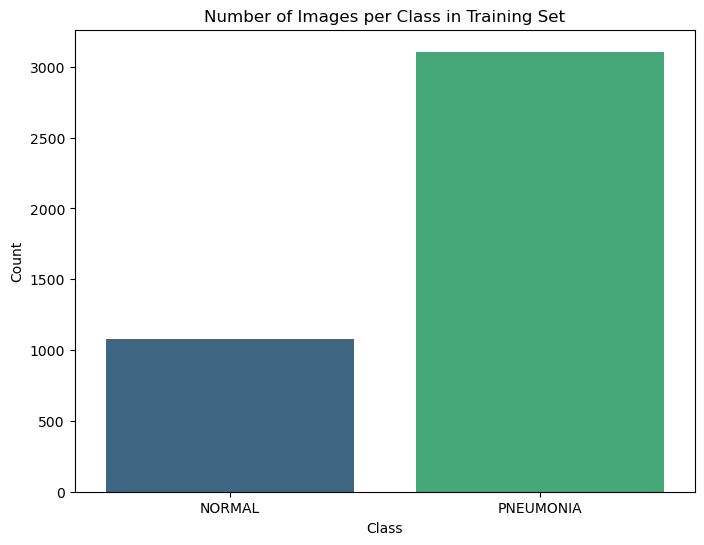

In [6]:
# Plotting the number of images per class in the training set
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_df, palette='viridis')
plt.title('Number of Images per Class in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['NORMAL', 'PNEUMONIA'])
plt.show()

It is evident from the plot above that the 'PNEUMONIA' class has over double the observations in the training set compared to the 'NORMAL' class. This can lead to bias and misleading evaluation metrics (e.g. accuracy loses meaning). A solution to this problem could be to employ the Matthews Correlation Coefficient (MCC): 

$$MCC = \frac{{TP \times TN - FP \times FN}}{{\sqrt{{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}}}$$


The MCC coefficient takes into account class imbalance, it ranges between $-1$ and $+1$, where $+1$ indicates a perfect prediction, $0$ indicates a random prediction, and $-1$ indicates a completely incorrect prediction.

Additionally, we can utilize weights appropriate for each class, based on each class label frequency in the training set.

In [7]:
# Calculating class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.9392956441149212, 1: 0.6736960721184804}


## Image Exploration

Finally, before proceeding to data preprocessing and visualization, we get a small random sample of images from the training set for inspection. This is useful for assessing data quality, understanding class distribution, and analyzing image properties such as size, intensity value ranges, and mean intensity values, thus ensuring that preprocessing techniques like normalization and data augmentation are appropriately tailored to the dataset and ultimately aiding in planning the preprocessing steps and addressing class imbalances effectively.

In [8]:
# Function to get random images and their labels
def get_random_images(dataframe, seed, sample_size):
    images = [] # initializing an empty list to store the images
    labels = [] # initializing an empty list to store the labels
    np.random.seed(seed) # setting the seed for reproducibility
    random_indices = dataframe.sample(n=sample_size, replace=False, random_state=seed).index # getting random indices
    # Iterating over the random indices
    for index in random_indices:
        image_path = dataframe['image_path'][index] # getting the image path
        image_label = dataframe['label'][index] # getting the image label
        image = Image.open(image_path) # opening the image
        images.append(image) # appending the image
        labels.append(image_label) # appending the label
    return images, labels # returning the images and labels

def plot_images(images, labels, row_num, col_num, verbose=2):
    fig, axes = plt.subplots(row_num, col_num, figsize=(20, 10))
    # Iterating over the images
    for i, image in enumerate(images):
        row = i // col_num # calculating the row number
        col = i % col_num # calculating the column number
        # Plotting the image
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # converting from (C, H, W) to (H, W, C)
            # Handle grayscale images
            if image.shape[2] == 1:
                image = image.squeeze(axis=2)
        else:
            image = np.array(image)  # converting PIL images to numpy arrays

        axes[row, col].imshow(image, cmap="gray" if len(image.shape) == 2 else None) #
        axes[row, col].axis('off')
        # Setting the title of the image based on the verbosity level
        if verbose == 1:
            axes[row, col].set_title(f"Label: {labels[i]}")
        elif verbose == 2:
            if isinstance(image, np.ndarray):
                size = image.shape
                intensity_min = np.min(image)
                intensity_max = np.max(image)
                intensity_mean = np.mean(image)
            else:
                size = image.size
                intensity_min = np.min(image)
                intensity_max = np.max(image)
                intensity_mean = np.mean(image)
            axes[row, col].set_title(f"Label: {labels[i]}\nSize: {size}\nIntensity: {round(intensity_min, 1)}-{round(intensity_max, 1)}, Mean: {round(intensity_mean, 1)}")
        else:
            raise ValueError("Verbose should be an int: 0, 1, or 2")
    
    plt.tight_layout()
    plt.show()

def plot_image_histograms(images, labels, row_num, col_num, verbose=2, single=True, normalized=False):
    fig, axes = plt.subplots(row_num, col_num, figsize=(20, 10))
    for i, image in enumerate(images):
        row = i // col_num
        col = i % col_num
        
        if isinstance(image, torch.Tensor):
            image_array = image.permute(1, 2, 0).numpy()  # converting from (C, H, W) to (H, W, C)
            if image_array.shape[2] == 1:
                image_array = image_array.squeeze(axis=2)  # handling grayscale images
        else:
            image_array = np.array(image)  # converting PIL images to numpy arrays

        if single and not normalized:
            hist, bins = np.histogram(image_array, bins=256, range=(0, 256))
            axes[row, col].plot(bins[:-1], hist)
        elif single and normalized:
            hist, bins = np.histogram(image_array, bins=256, range=(0, 1))
            axes[row, col].plot(bins[:-1], hist)
        elif not single and normalized:
            for channel in range(3):
                hist, bins = np.histogram(image_array[:, :, channel], bins=256, range=(0, 1))
                axes[row, col].plot(bins[:-1], hist, label=f"Channel {channel}")
        else:
            for channel in range(3):
                hist, bins = np.histogram(image_array[:, :, channel], bins=256, range=(0, 256))
                axes[row, col].plot(bins[:-1], hist, label=f"Channel {channel}")

        if verbose == 1:
            axes[row, col].set_title(f"Label: {labels[i]}")
        elif verbose == 2:
            axes[row, col].set_title(f"Label: {labels[i]}\nSize: {image_array.shape}\nIntensity: {round(np.min(image_array), 1)}-{round(np.max(image_array), 1)}, Mean: {round(np.mean(image_array), 1)}")
        else:
            raise ValueError("Verbose should be an int: 0, 1, or 2")
    
    plt.tight_layout()
    plt.show()

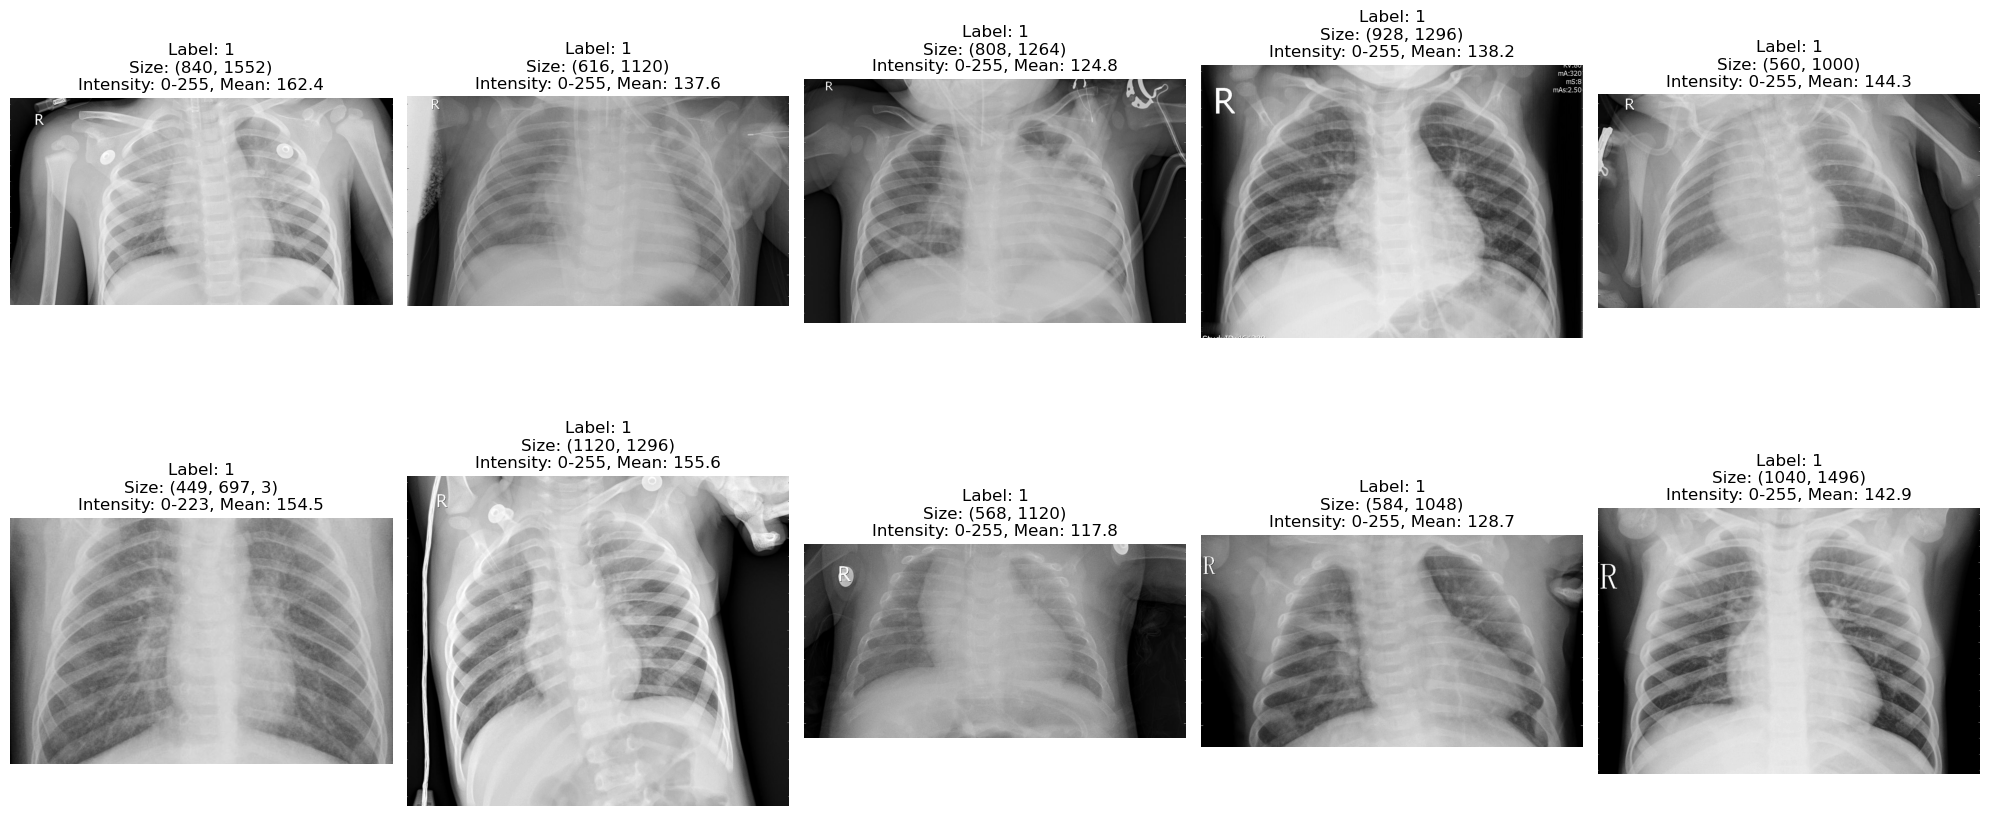

In [9]:
# Getting a random sample of images from the training set
images, labels = get_random_images(dataframe=train_df, seed=84, sample_size=10)

# Plotting the images with their properties
plot_images(images, labels, row_num=2, col_num=5, verbose=2)

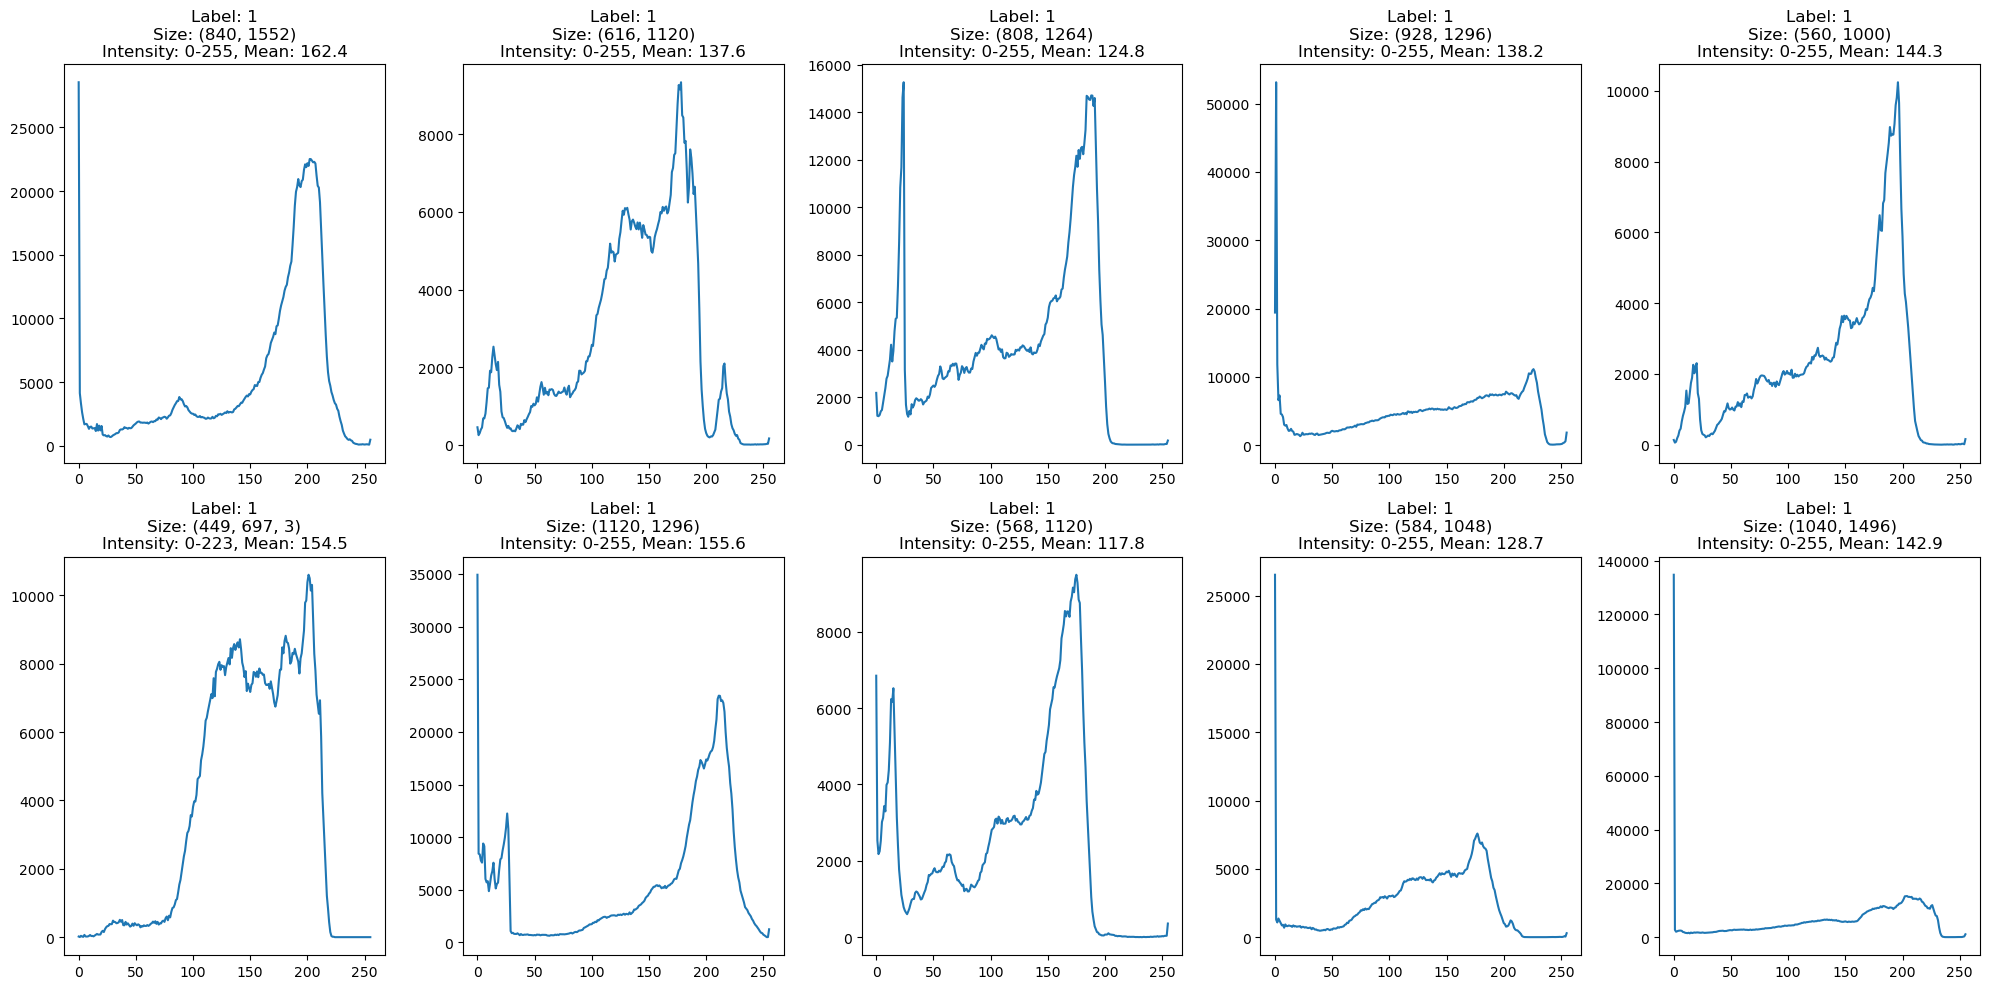

In [10]:
# Plotting the histograms of the images
plot_image_histograms(images, labels, row_num=2, col_num=5, verbose=2, single=True, normalized=False)

We can observe that the images in the training set have various different sizes and average instensity pixel values, while some of them seem to be slightly rotated. In addition, even though all images have completely black pixels with intensity equal to $0$, some images do not have pixels that reach the maximum intensity of $255$. From all of these, we get a good idea of the preprocessing and transformation techniques we should apply on the dataset.

# <ins>Data Preprocessing and Visualization</ins>

We need to define our actual dataset before proceeding with preprocessing. While dataframes have been useful so far, a more robust method is required for loading images and labels. Therefore, we will create a custom dataset by inheriting from PyTorch's `Dataset` class. This custom dataset will efficiently handle image retrieval and transformations for the training, test, and validation sets, and crucially, it will apply the transformations we will define.

Like previously mentioned, our custom `PneumoniaDataset` class is a subclass of the `Dataset` class from the `torch.utils.data` module. It represents a dataset of pneumonia-related images and their corresponding labels. Here's a summary of what each method does:

* `__init__(self, dataframe, transform=None)`: Initializes the PneumoniaDataset with a provided dataframe and an optional transform function.
* `__len__(self)`: Returns the length of the dataset by returning the number of elements in the data attribute.
* `__getitem__(self, idx)`: Returns a tuple containing the image and label at the given index. It retrieves the image path and label from the dataframe, opens the image, applies any specified transformations, and returns the image and label as a tuple.

In [9]:
class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Initializes the PneumoniaDataset with the provided dataframe and optional transform function.

        Parameters:
            dataframe: The dataframe containing the data.
            transform: A function to apply transformations to the data (default is None).
        """
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        """
        Calculates the length of the dataset by returning the number of elements in the `data` attribute.

        Returns:
            int: The length of the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get the item at the specified index from the dataset.

        Parameters:
            idx (int): The index of the item to retrieve.

        Returns:
            tuple: A tuple containing the image and label at the specified index.
                - image (PIL.Image.Image or torch.Tensor): The image at the specified index.
                - label (torch.Tensor): The label at the specified index, converted to a tensor.
        """
        image_path = self.data['image_path'][idx] # getting the image path
        label = self.data['label'][idx] # getting the label
        label = torch.tensor(label) # converting the label to a tensor
        image = Image.open(image_path) # opening the image
        image = ImageOps.equalize(image) # applying histogram equalization
        # Applying the transform function if it is not None
        if self.transform is not None:
            image = self.transform(image)
        return image, label # returning the image and label

It is essential to handle data augmentation carefully, as pretrained CNN models require specific preprocessing that differs from classical ML approaches or custom CNN models trained from scratch. We will define separate transformations to match the preprocessing used by most pretrained CNNs (as detailed in the [the Pytorch documentation](https://pytorch.org/vision/stable/models.html)). Additionally, since most pretrained models are trained on 3-channel RGB images, we will replicate the grayscale intensity across three dimensions for compatibility. We also note that deeper models require stronger data augmentation to prevent overfitting.

The two separate augmentation pipelines for the training set are as follows: 

For the pretrained model:
* Convert grayscale images to RGB for model compatibility.
* Apply histogram equalization to ensure contrast consistency.
* Resize images to $256 \times 256$ with bicubic interpolation, matching the pretrained model requirements.
* Apply a $10\%$ translation either vertically or horizontally.
* Rotate images randomly between $+20$ and $-20$ degrees to account for rotational variance.
* Center crop to align with the majority of pretrained models' preprocessing.
* Normalize using the standard values applied in most pretrained models.

For the classical ML approach and custom CNN implementation:
* Convert all images to grayscale to ensure format consistency.
* Apply histogram equalization to ensure contrast consistency.
* Resize images to $256 \times 256$ for size uniformity.
* Apply random rotations between $+15$ and $-15$ degrees to handle rotational variance.
* Center crop the images.
* Apply simple min-max normalization for feature scaling.

For the validation and test sets, we will only resize and scale the images according to the input size and scaling method, without additional augmentations.

In [10]:
# Pre-trained model transforms for training
train_transforms_pretrained = transforms.Compose([ 
    transforms.Grayscale(num_output_channels=3), # converting grayscale images to RGB
    transforms.Resize((256, 256), interpolation=Image.BICUBIC), # resizing the image to 256x256 with bicubic interpolation
    transforms.RandomHorizontalFlip(p=0.5), # randomly flipping the image horizontally with a probability of 0.5
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.1, 0.1))], p=0.5), # randomly applying a 10% translation either horizontally or vertically with a probability of 0.5
    transforms.RandomRotation((-20, 20)), # randomly rotating the image between -20 and 20 degrees
    transforms.CenterCrop(224), # center cropping the image to 224x224
    transforms.ToTensor(), # converting the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalizing the image
])

# Pre-trained model transforms for test and validation
test_val_transforms_pretrained = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # converting grayscale images to RGB
    transforms.Resize((224, 224), interpolation=Image.BICUBIC), # resizing the image to 224x224 with bicubic interpolation
    transforms.ToTensor(), # converting the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalizing the image
])

# Classical model transforms for training
train_transforms_classic = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # converting images to grayscale
    transforms.Resize((256, 256)), # resizing the image to 256x256
    transforms.RandomHorizontalFlip(p=0.5), # randomly flipping the image horizontally with a probability of 0.5
    transforms.RandomRotation((-15, 15)), # randomly rotating the image between -15 and 15 degrees
    transforms.CenterCrop(224), # center cropping the image to 224x224
    transforms.ToTensor(), # converting the image to a tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) # normalizing the image
])

# Classical model transforms for test and validation
test_val_transforms_classic = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # converting images to grayscale
    transforms.Resize((224, 224)), # resizing the image to 224x224
    transforms.ToTensor(), # converting the image to a tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) # normalizing the image
])

# Datasets for pretrained model
train_dataset_pretrained = PneumoniaDataset(train_df, transform=train_transforms_pretrained)
val_dataset_pretrained = PneumoniaDataset(val_df, transform=test_val_transforms_pretrained)
test_dataset_pretrained = PneumoniaDataset(test_df, transform=test_val_transforms_pretrained)

# Datasets for classical ML and custom CNN
train_dataset_classic = PneumoniaDataset(train_df, transform=train_transforms_classic)
val_dataset_classic = PneumoniaDataset(val_df, transform=test_val_transforms_classic)
test_dataset_classic = PneumoniaDataset(test_df, transform=test_val_transforms_classic)

The following code retrieves and visualizes the first 10 images from the training dataset for both the pretrained model and the classical ML/Custom CNN models.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

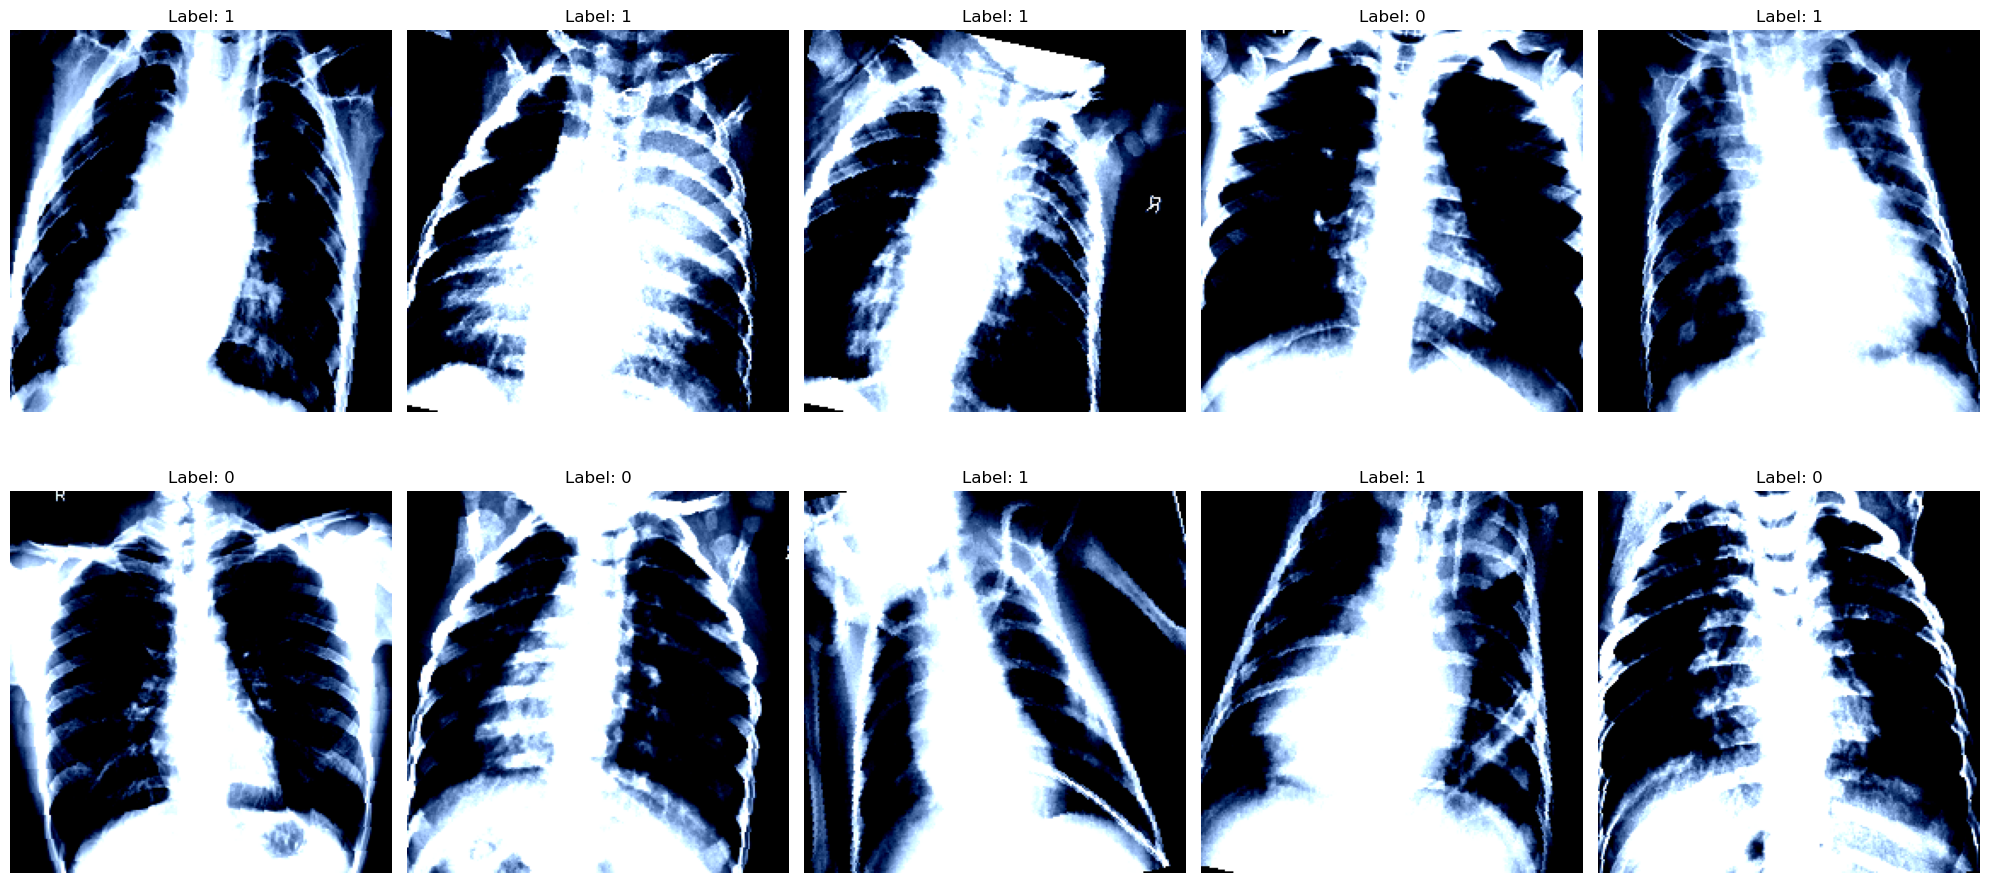

In [13]:
# Function to get the first N images from a dataset
def get_first_n_images(dataset, n=10):
    images = []
    labels = []
    for i in range(n):
        image, label = dataset[i]
        images.append(image)
        labels.append(label.item())
    return images, labels

# Getting the first 10 images for the pretrained model
images_pretrained, labels_pretrained = get_first_n_images(train_dataset_pretrained, n=10)

# Getting the first 10 images for the classical ML and custom CNN
images_classic, labels_classic = get_first_n_images(train_dataset_classic, n=10)

# Displaying the first 10 images for the pretrained model
plot_images(images_pretrained, labels_pretrained, row_num=2, col_num=5, verbose=1)


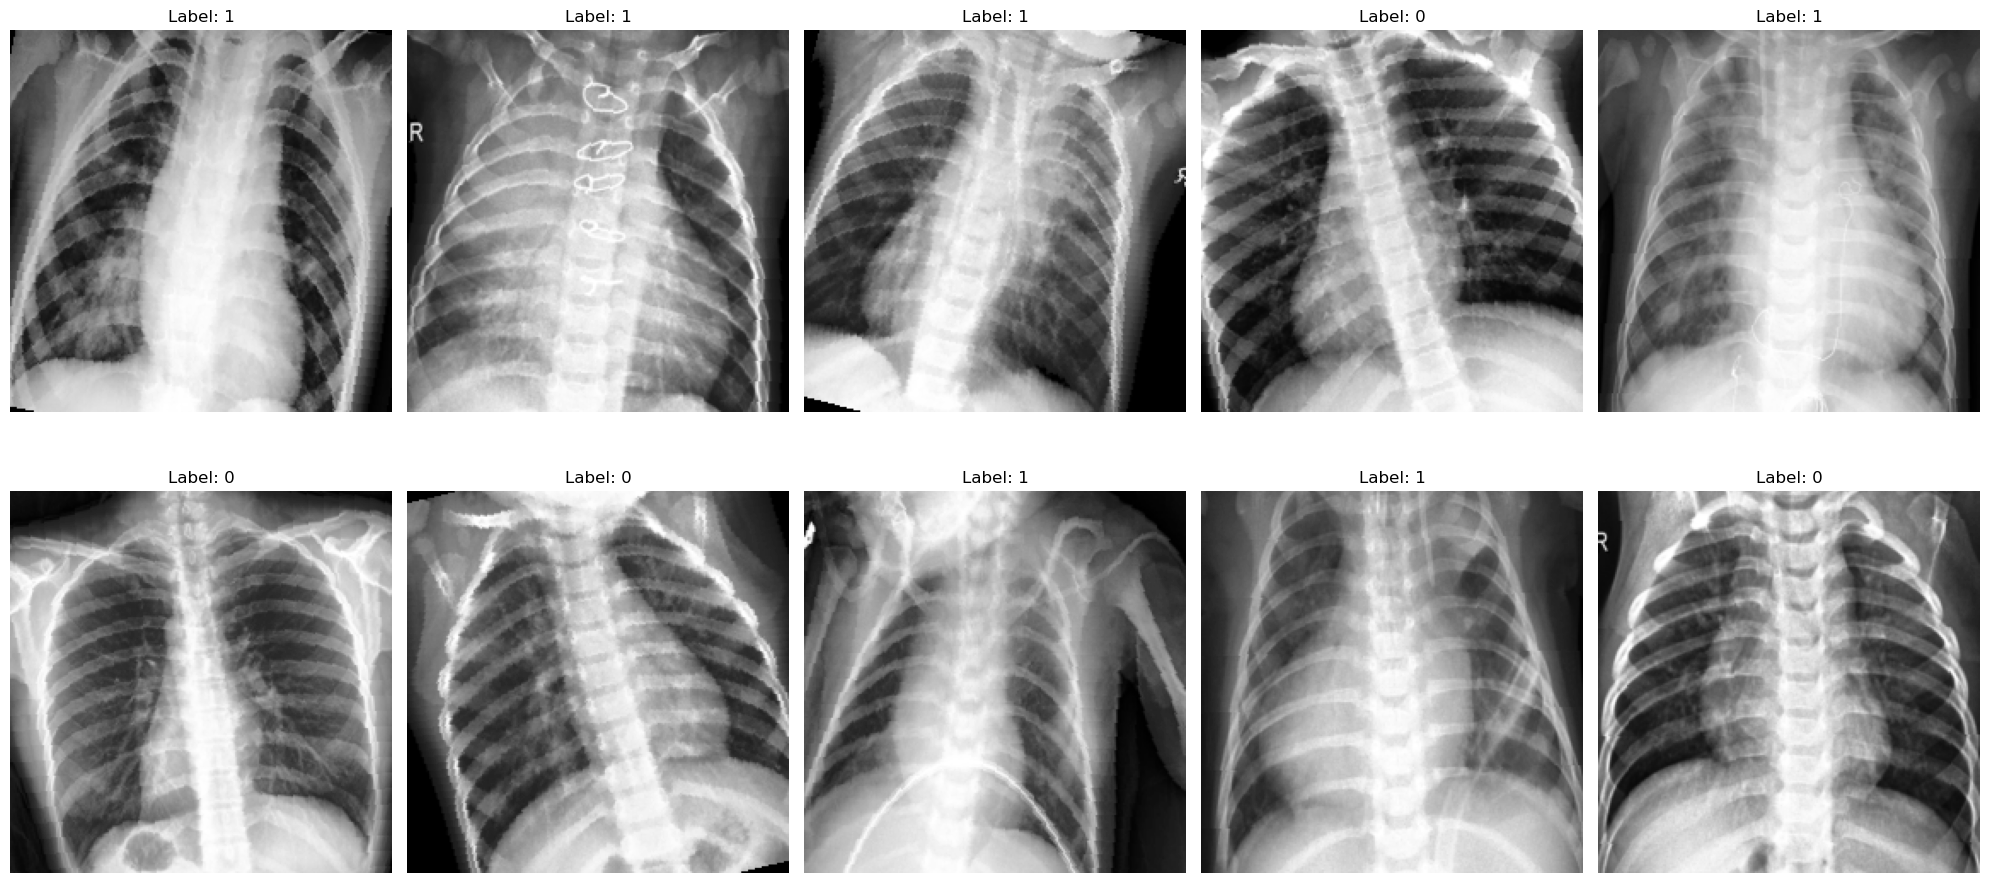

In [14]:
# Displaying the first 10 images for the classical ML and custom CNN
plot_images(images_classic, labels_classic, row_num=2, col_num=5, verbose=1)

# <ins>Developing Detection Algorithms</ins>

## Classical Machine Learning Techniques with Universal Feature Extraction using Dimensionality Reduction

For this approach, we first need to flatten the images in the dataset. By doing that, we now have a feature vector with $224 \times 224 = 50176$ features per image, along with their target labels, which are single integers.

In [11]:
def flatten_dataset(dataset):
    """
    A function to flatten a dataset of images and corresponding labels into X and y arrays.
    """
    X = np.zeros((len(dataset), 224 * 224 * (3 if dataset[0][0].shape[0] == 3 else 1))) # 224x224x3 if RGB, 224x224x1 if grayscale
    y = np.zeros((len(dataset))) # labels
    # Loop over the dataset
    for i in range(len(dataset)):
        image, label = dataset[i] # getting the image and label
        flattened_image = image.permute(1, 2, 0).reshape(-1).numpy()  # flattening the image
        X[i, :] = flattened_image # adding the flattened image to the X array
        y[i] = label.item() # adding the label to the y array
    return X, y # returning the X and y arrays

# Flattening the datasets for classical ML and custom CNN
X_train, y_train = flatten_dataset(train_dataset_classic)
X_val, y_val = flatten_dataset(val_dataset_classic)
X_test, y_test = flatten_dataset(test_dataset_classic)

With CNNs, we can achieve automatic feature extraction. However, this is not the case for classical machine learning. For this purpose, we can utilize Truncated SVD instead of PCA because our matrix is sparse with many zero values due to dark pixels. We retain the components necessary to achieve approximately 95% cumulative variance.

In [12]:
# Performing Truncated SVD
svd = TruncatedSVD(n_components=900, random_state=42) # reducing the dimensionality to 900 components
X_train_svd = svd.fit_transform(X_train) # transforming the training data

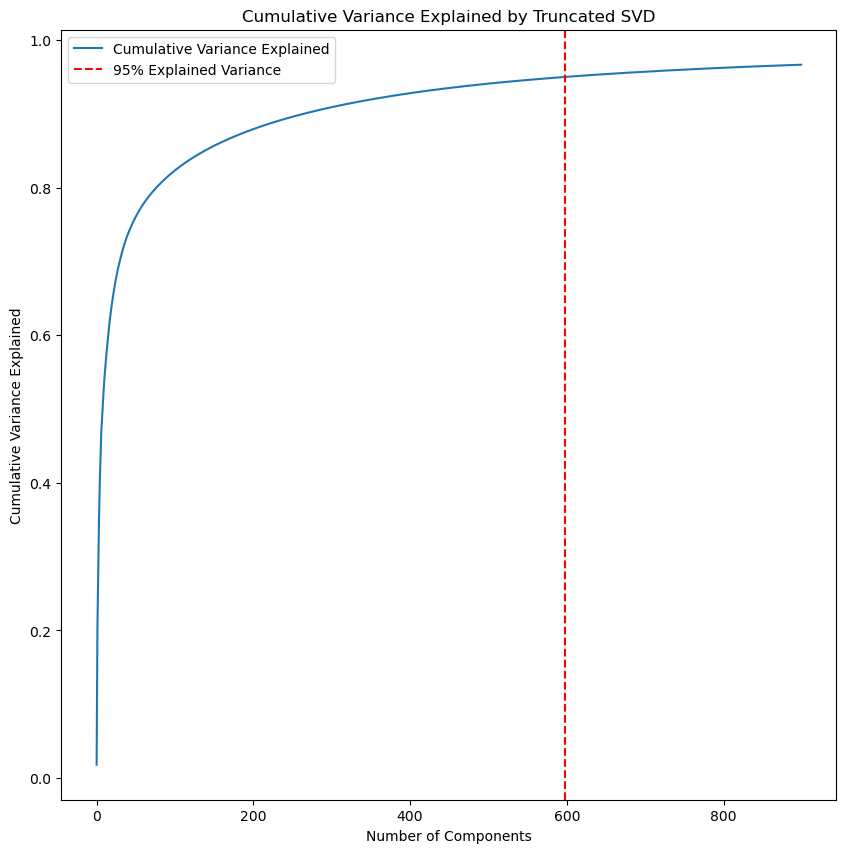

95% variance is achieved at 598 Principal Components


In [13]:
# Calculating cumulative variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Finding the index where cumulative variance exceeds 95%
explained_variance_ratio_95 = 0.95
index_95 = np.argmax(cumulative_variance >= explained_variance_ratio_95)

# Plotting cumulative variance
plt.figure(figsize=(10, 10))
plt.plot(cumulative_variance, label='Cumulative Variance Explained')
plt.axvline(x=index_95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.title('Cumulative Variance Explained by Truncated SVD')
plt.show()

print(f"95% variance is achieved at {index_95} Principal Components")

In [14]:
X_train_svd = X_train_svd[:,:index_95] # reducing the dimensionality of the training set to 599 components (95% explained variance)

Now that we have determined the feature extraction method, we apply the appropriate transformation to the validation and test sets.

In [15]:
X_test_svd = svd.transform(X_test) # transforming the test data
X_val_svd = svd.transform(X_val) # transforming the validation data
X_test_svd = X_test_svd[:,:index_95] # reducing the dimensionality of the test set to 599 components (95% explained variance)
X_val_svd = X_val_svd[:,:index_95] # reducing the dimensionality of the validation set to 599 components (95% explained variance)

We then create a function to evaluate our predictions using various metrics and visualize the results. The metrics we use are:

* __ROC AUC__: This is the area under the ROC curve, with scores weighted based on the support of each class, ranging from 0 to 1.
* __Matthews Correlation Coefficient (MCC)__: A balanced metric adjusted for class imbalance, with a value range of -1 to 1.
* __Precision__: The proportion of true positive predictions (patients correctly identified as having pneumonia) over all positive predictions (all patients predicted as having pneumonia).
* __Recall__: The proportion of true positive predictions (patients correctly identified as having pneumonia) over all actual positives (all patients who actually have pneumonia).
* __F1 Score__: The harmonic mean of precision and recall.
* __Accuracy__: Measures the overall label matching between true and predicted values. However, accuracy is not a reliable metric for imbalanced problems and is used here for comparison only.
* __Balanced Accuracy__: The average recall obtained on each class, adjusted for class imbalance.

Therefore, since our dataset is imbalanced, the two most important metrics to focus on are balanced accuracy and MCC.

In [16]:
def metrics(y_test, y_pred):
    """
    A function to compute various classification metrics based on the predicted and true labels.
    Parameters:
        y_test (array-like): True labels.
        y_pred (array-like): Predicted labels.
    Returns:
        dict: A dictionary containing the computed metrics such as F1 score, Balanced Accuracy, Precision, MCC, Recall, ROC AUC, and Accuracy.
    """
    # Computing the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Computing the various metrics
    roc = roc_auc_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred, adjusted=True)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Storing the metrics in a dictionary
    metrics_dict = {
        "F1": f1, 
        "Balanced Accuracy": balanced_accuracy, 
        "Precision": precision, 
        "MCC": mcc,
        "Recall": recall, 
        "ROC AUC": roc, 
        "Accuracy": accuracy
    }
    
    # Plotting the confusion matrix and the various metrics
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", ax=axes[0], cmap='Blues') # annot=True to annotate cells, fmt="d" to display integers
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Truth')
    
    # Metrics
    df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Score'])
    sns.heatmap(df, annot=True, cmap='coolwarm', ax=axes[1], cbar=True) # annot=True to annotate cells
    axes[1].set_title('Scores')
    
    plt.tight_layout()
    plt.show()
    
    return metrics_dict

### Gaussian Naive Bayes (GNB) Baseline Classifier

Baseline classifiers are mathematically simple and do not require hyperparameter tuning. They provide a foundation for evaluating the performance of more complex models that we will explore later. Since the Gaussian Naive Bayes (GNB) classifier does not require tuning, it can be used as a baseline classifier for comparison with other models.

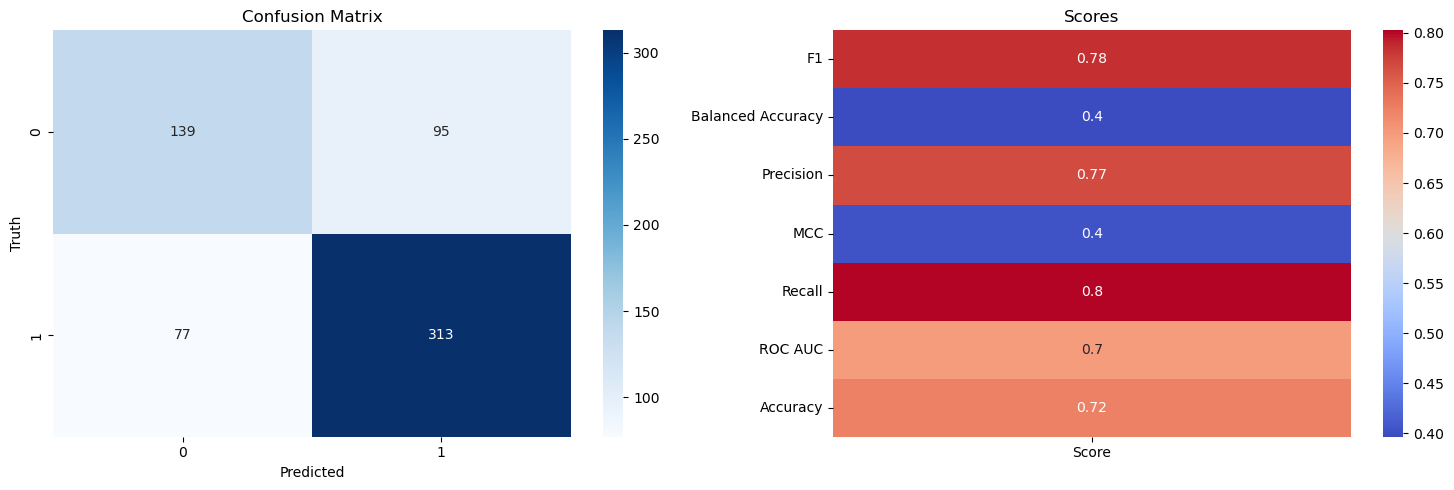

Gaussian Naive Bayes Scores:
F1: 0.7845
Balanced Accuracy: 0.3966
Precision: 0.7672
MCC: 0.4036
Recall: 0.8026
ROC AUC: 0.6983
Accuracy: 0.7244


In [21]:
# Initializing the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Fitting the classifier on the training data
gnb.fit(X_train_svd, y_train)

# Predicting on the test data
y_pred = gnb.predict(X_test_svd)

# Evaluating the predictions and visualizing the results using the metrics function
gnb_scores = metrics(y_test, y_pred)

# Printing the metrics
print("Gaussian Naive Bayes Scores:")
for metric, value in gnb_scores.items():
    print(f"{metric}: {value:.4f}")

### Linear Discriminant Analysis (LDA) Baseline Classifier

The Gaussian Naive Bayes (GNB) is a generative classifier that requires more parameters than discriminative classifiers, making it susceptible to the curse of dimensionality in this dataset. Linear Discriminant Analysis (LDA) assumes that the data follows a normal distribution and that the class covariances are equal. It projects the original feature space onto a lower-dimensional space by maximizing the separation between classes while minimizing the variance within each class, and then fits a linear separation hyperplane.

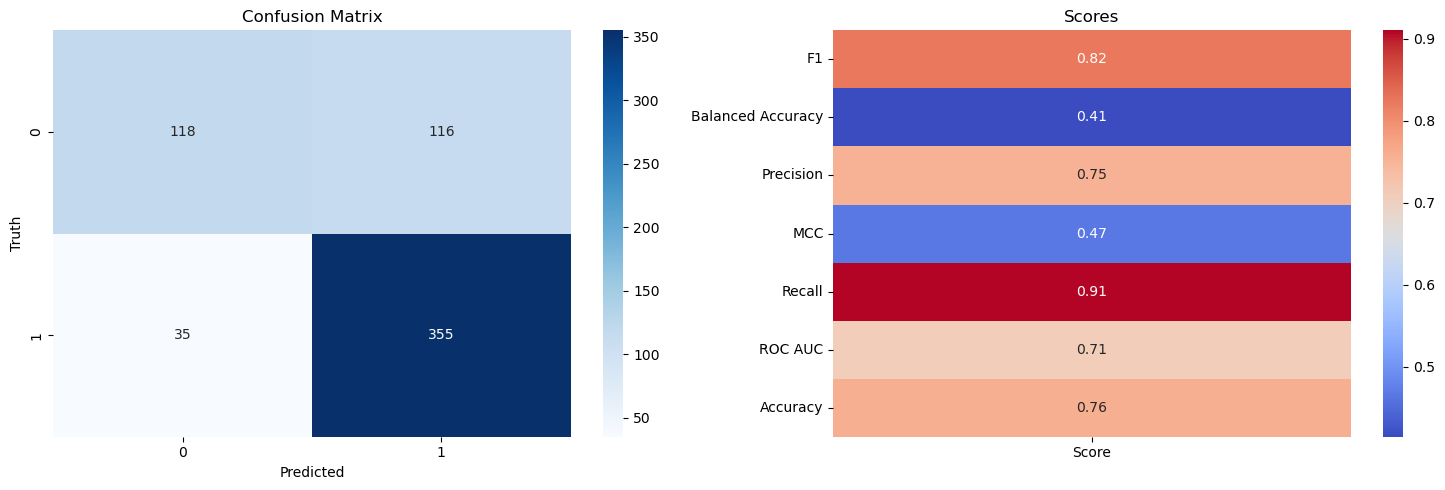

Linear Discriminant Analysis Scores:
F1: 0.8246
Balanced Accuracy: 0.4145
Precision: 0.7537
MCC: 0.4665
Recall: 0.9103
ROC AUC: 0.7073
Accuracy: 0.7580


In [22]:
# Initializing the Linear Discriminant Analysis classifier
lda = LinearDiscriminantAnalysis()

# Fitting the classifier on the training data
lda.fit(X_train_svd, y_train)

# Predicting on the test data
y_pred = lda.predict(X_test_svd)

# Evaluating the predictions and visualizing the results using the metrics function
lda_scores = metrics(y_test, y_pred)

# Printing the metrics
print("Linear Discriminant Analysis Scores:")
for metric, value in lda_scores.items():
    print(f"{metric}: {value:.4f}")

The following classifiers require hyperparameter tuning using the validation set but also offer the advantages of regularization and the ability to account for class weights, which can significantly enhance their performance. 

### Logistic Regression (LR) Classifier

Logistic regression (LR) is a linear classification model that incorporates regularization through:
* __C__: This parameter represents the inverse of the regularization strength in logistic regression. It controls the amount of regularization applied by multiplying the value of C with the norm of the coefficients. Smaller values indicate stronger regularization.
* __penalty__: This parameter specifies the type of regularization to apply, either the l1 or l2 norm of the coefficients, which is added as a regularization term.

We use Optuna's Bayesian optimization to fine-tune these hyperparameters by maximizing the Matthews Correlation Coefficient (MCC) on the validation set. By choosing MCC as the metric to optimize, we aim for a balanced classifier that doesn't heavily favor any particular class. Additionally, we use the class weights computed during the data exploration phase.

In [23]:
# Defining the objective function for Optuna
def objective(trial):
    """
    This function uses the Optuna library for hyperparameter tuning. It defines the objective function that is used to evaluate different hyperparameters for the Logistic Regression model.
    The function suggests values for the penalty and C hyperparameters using the Optuna trial object. 
    It then initializes the Logistic Regression model with the suggested hyperparameters and fits it on the training data. 
    Finally, it predicts on the validation data and calculates the Matthews correlation coefficient (MCC) to evaluate the performance of the model.
    
    Args:
        trial (optuna.trial.Trial): The trial object for hyperparameter tuning.    
    """
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2']) # l1 lasso, l2 ridge
    C = trial.suggest_float('C', 0.001, 100.0, log=True) # inverse of regularization strength
    lr = LogisticRegression(penalty=penalty, C=C, solver='liblinear', random_state=42, class_weight=class_weights_dict) # initializing the Logistic Regression model
    
    lr.fit(X_train_svd, y_train) # fitting the model
    y_pred = lr.predict(X_val_svd) # predicting on the validation data
    mcc = matthews_corrcoef(y_val, y_pred) # computing the MCC
    
    return mcc # returning the MCC

# Creating Optuna study
sampler = optuna.samplers.TPESampler(multivariate=True, seed=42, warn_independent_sampling=False) # using TPESampler
pruner = optuna.pruners.HyperbandPruner() # using HyperbandPruner
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner) # creating Optuna study
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1) # optimizing the objective function

# Getting the best parameters and value
best_params = study.best_params # best parameters
best_mcc = study.best_value # best value

print("Best Parameters:", best_params)
print("Best MCC:", best_mcc)

  0%|          | 0/50 [00:00<?, ?it/s]

Best trial: 26. Best value: 0.628102: 100%|██████████| 50/50 [10:05<00:00, 12.11s/it]

Best Parameters: {'penalty': 'l2', 'C': 0.001068543752849999}
Best MCC: 0.6281019063082396


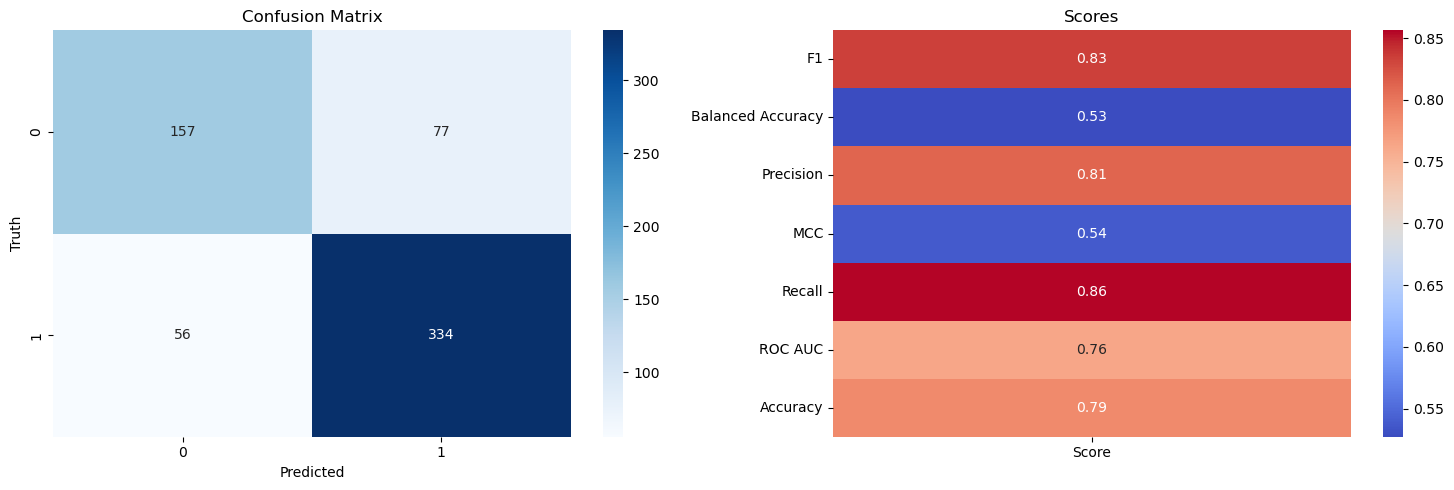

Logistic Regression Scores:
F1: 0.8340
Balanced Accuracy: 0.5274
Precision: 0.8127
MCC: 0.5384
Recall: 0.8564
ROC AUC: 0.7637
Accuracy: 0.7869


In [24]:
# Training the final Logistic Regression model with the best parameters
lr = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver='liblinear', random_state=42, class_weight=class_weights_dict)
lr.fit(X_train_svd, y_train)

# Predicting on the test data
y_pred = lr.predict(X_test_svd)

# Evaluating the predictions and visualizing the results using the metrics function
lr_scores = metrics(y_test, y_pred)

# Printing the metrics
print("Logistic Regression Scores:")
for metric, value in lr_scores.items():
    print(f"{metric}: {value:.4f}")

### Support Vector Machines (SVMs) Classifier (SVC)

Like with logistic regression, in support vector machines (SVMs) we use Optuna's Bayesian optimization to fine-tune hyperparameters by maximizing the Matthews Correlation Coefficient (MCC) on the validation set. The hyperparameters we optimize include:

* __C__: This represents the regularization strength. A lower value of C allows for a smaller margin, which can lead to the SVM classifier attempting to classify all training examples correctly, potentially resulting in overfitting. Conversely, a higher value of C encourages a larger margin, permitting some misclassifications in the training set, which can enhance generalization on new data.
* __Kernel__: This defines the kernel trick used to transform the input features. We allow a choice between a linear kernel, a radial basis function (RBF) kernel, and a sigmoid kernel.
* __Gamma__: This parameter influences the smoothness of the decision boundary. It can be set to gamma='scale', where it uses 1 / (n_features * X.var()), or gamma='auto', where it uses 1 / n_features.

In [25]:
# Defining the objective function for Optuna
def objective(trial):
    """
    This function uses the Optuna library for hyperparameter tuning. It defines the objective function that is used to evaluate different hyperparameters for the SVC model.
    The function suggests values for the 'C', 'kernel', and 'gamma' hyperparameters using the Optuna trial object. 
    It then initializes the SVC model with the suggested hyperparameters and fits it on the training data. 
    Finally, it predicts on the validation data and calculates the Matthews correlation coefficient (MCC) to evaluate the performance of the model.
    
    Args:
        trial (optuna.trial.Trial): The trial object for hyperparameter tuning.   
    """
    C = trial.suggest_float('C', 0.001, 100.0, log=True) # inverse of regularization strength
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid']) # kernel type
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel != 'linear' else 'scale' # kernel coefficient
    svm = SVC(C=C, kernel=kernel, gamma=gamma, class_weight=class_weights_dict, random_state=42) # initializing the SVC model
    
    svm.fit(X_train_svd, y_train) # fitting the model
    y_pred = svm.predict(X_val_svd) # predicting on the validation data
    mcc = matthews_corrcoef(y_val, y_pred) # computing the MCC
    return mcc

# Creating Optuna study
sampler = optuna.samplers.TPESampler(multivariate=True, seed=42, warn_independent_sampling=False) # using TPESampler
pruner = optuna.pruners.HyperbandPruner() # using HyperbandPruner
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner) # creating Optuna study
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1) # optimizing the objective function

# Getting the best parameters and value
best_params = study.best_params # best parameters
best_mcc = study.best_value # best value

print("Best Parameters:", best_params)
print("Best MCC:", best_mcc)

Best trial: 47. Best value: 0.791404: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it]

Best Parameters: {'C': 25.69619982528142, 'kernel': 'rbf', 'gamma': 'scale'}
Best MCC: 0.7914037319379099


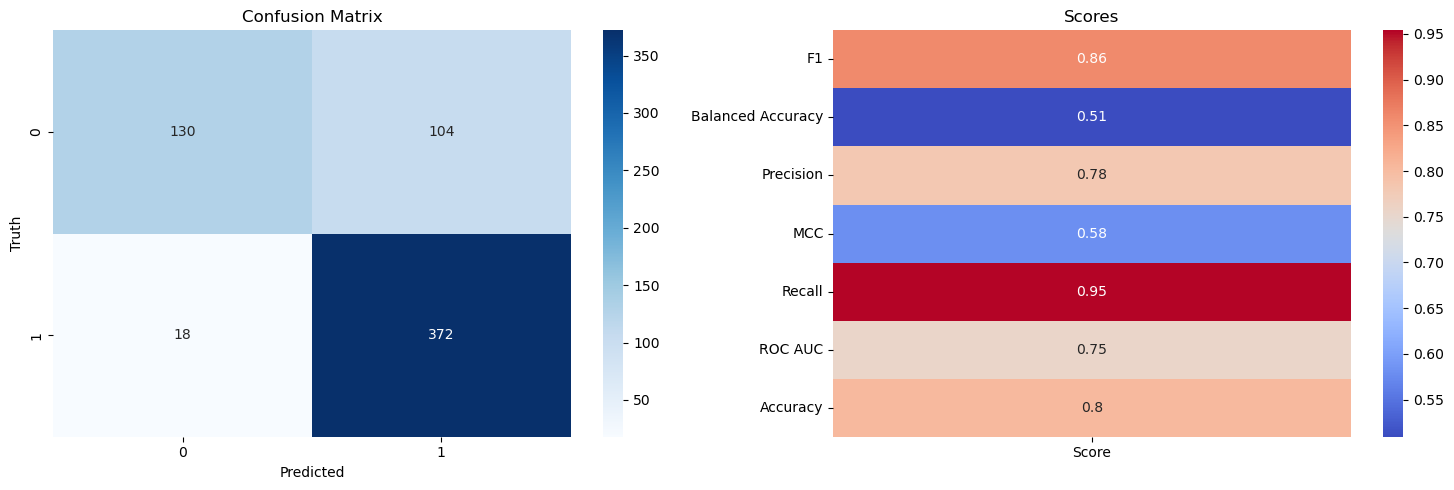

Support Vector Classifier Scores:
F1: 0.8591
Balanced Accuracy: 0.5094
Precision: 0.7815
MCC: 0.5798
Recall: 0.9538
ROC AUC: 0.7547
Accuracy: 0.8045


In [26]:
# Training the final SVM model with the best parameters
svc = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'], class_weight=class_weights_dict, random_state=42)
svc.fit(X_train_svd, y_train)

# Predicting on the test data
y_pred = svc.predict(X_test_svd)

# Evaluating the predictions and visualizing the results using the metrics function
svc_scores = metrics(y_test, y_pred)

# Printing the metrics
print("Support Vector Classifier Scores:")
for metric, value in svc_scores.items():
    print(f"{metric}: {value:.4f}")

We observe that when it comes to balanced accuracy and MCC, Logistic Regression and Support Vector Machines perform notably better compared to the baseline Gaussian Naive Bayes and Linear Discriminant Analysis classifiers.

## Classical Machine Learning Techniques With Image-Specific Feature Extraction

We need rotation-invariant features, since rotation has been applied as an augmentation step, so we focus on the following:

1. __Statistical Metrics of Intensity Distribution__: These metrics provide an understanding of the overall intensity characteristics of the image, helping in capturing essential features irrespective of the image orientation.
2. __Perimeter Calculation__: We use the Canny edge detector to identify edges and then count all non-zero values to determine the perimeter. This method accurately captures the boundary information by focusing on edge pixels.
3. __Hu Moments__: Hu Moments are critical as they are invariant to translation, scale, and rotation, making them robust for shape analysis and recognition tasks. Each Hu Moment value encapsulates specific characteristics of the image contour:
    * Hu1: Represents the overall size or scale of the object’s contour.
    * Hu2: Captures the rotational aspects of the object’s contour.
    * Hu3: Quantifies mirror symmetry or reflection properties.
    * Hu4: Characterizes elongation or thinness of the contours.
    * Hu5: Relates to the curvature or bending of the object’s contour.
    * Hu6: Represents higher-order variations in the contour.
    * Hu7: Reflects the smoothness or roundedness of the object’s contour.

In [28]:
def build_features(dataset):
    """
    This function builds features for a given dataset by iterating over each image in the dataset.
    The features include the intensity (mean and standard deviation) and perimeter of the image.
    It also calculates the Hu moments of the image if it contains any contours.

    The resulting features are stored in a numpy array of shape (len(dataset), 13).
    The first two columns correspond to the intensity features (mean and standard deviation).
    The third column corresponds to the perimeter of the image.
    The next seven columns correspond to the Hu moments of the image if it contains any contours,
    otherwise they are set to zero.

    The function assumes that the dataset is a list of tuples, where each tuple contains an image
    and its label. The image is assumed to be a tensor and is converted to a numpy array.

    Note: The function assumes that the image is a 2D grayscale image.

    Args:
        dataset (list): A list of tuples containing an image and its label.

    Returns:
        numpy.ndarray: A numpy array of shape (len(dataset), 13) containing the built features.
    """
    X = np.zeros((len(dataset), 13)) # initializing the features array with zeros (13 features)
    # Looping over the dataset
    for i in range(len(dataset)):
        image, _ = dataset[i] # getting the image
        image = image.squeeze().numpy() # converting to numpy array and removing channel dimension if present
        
        # Intensity 
        X[i, 0] = np.mean(image) # mean intensity
        X[i, 1] = np.std(image) # standard deviation of intensity
        
        # Perimeter 
        edges = skif.canny(image, sigma=3) # applying Canny edge detection to the image
        X[i, 2] = np.count_nonzero(edges) # number of edges in the image
        
        # Moments
        thresholded = image > 0.5 # thresholding the image
        contours = measure.find_contours(thresholded, 0.5, fully_connected='high') # finding contours
        # If the image contains any contours
        if contours:
            moments = measure.moments(contours[0]) # computing the moments
            hu_moments = measure.moments_hu(moments) # computing the Hu moments
            X[i, 3:10] = hu_moments # storing the Hu moments
        else:
            X[i, 3:10] = np.zeros(7) # setting the Hu moments to zero if no contours are found
        
    return X # returning the features array

# Building features for the training, validation, and test datasets
X_train_fe = build_features(train_dataset_classic)
X_val_fe = build_features(val_dataset_classic)
X_test_fe = build_features(test_dataset_classic)

We also perform standardization on the datasets.

In [30]:
# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler on the training data and transform the training data
X_train_fe = scaler.fit_transform(X_train_fe)

# Transforming the validation and test data using the fitted scaler
X_val_fe = scaler.transform(X_val_fe)
X_test_fe = scaler.transform(X_test_fe)

### Gaussian Naive Bayes (GNB) Baseline Classifier

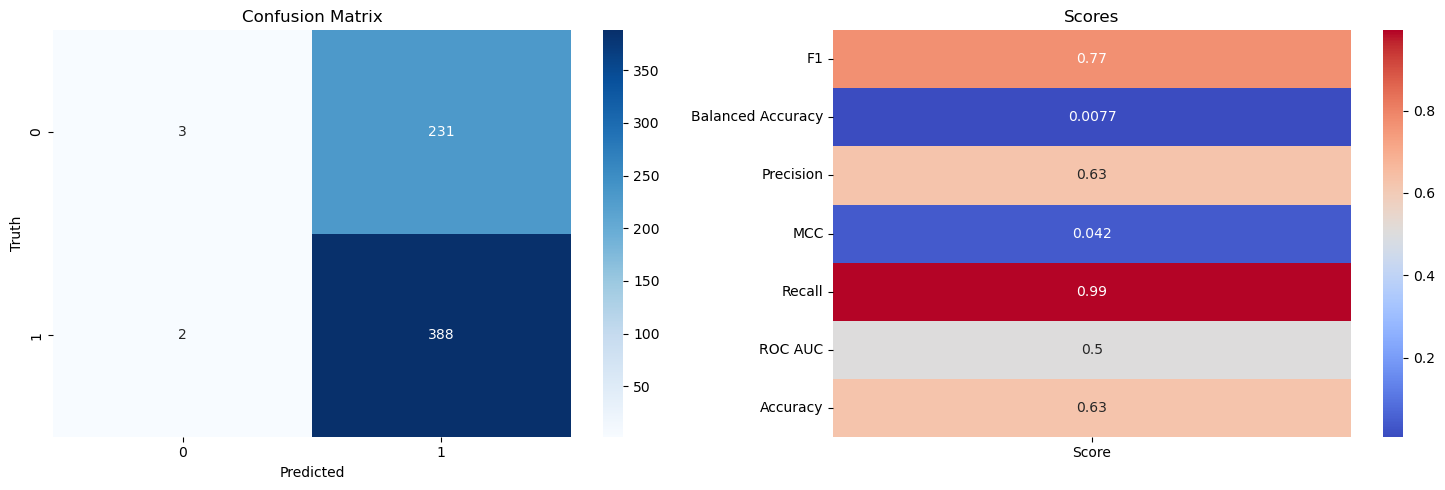

Gaussian Naive Bayes Scores:
F1: 0.7691
Balanced Accuracy: 0.0077
Precision: 0.6268
MCC: 0.0418
Recall: 0.9949
ROC AUC: 0.5038
Accuracy: 0.6266


In [31]:
# Initializing the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Fitting the classifier on the training data
gnb.fit(X_train_fe, y_train)

# Predicting on the test data
y_pred = gnb.predict(X_test_fe)

# Evaluating the predictions and visualizing the results using the metrics function
gnb_scores = metrics(y_test, y_pred)

# Printing the metrics
print("Gaussian Naive Bayes Scores:")
for metric, value in gnb_scores.items():
    print(f"{metric}: {value:.4f}")

### Linear Discriminant Analysis (LDA) Baseline Classifier

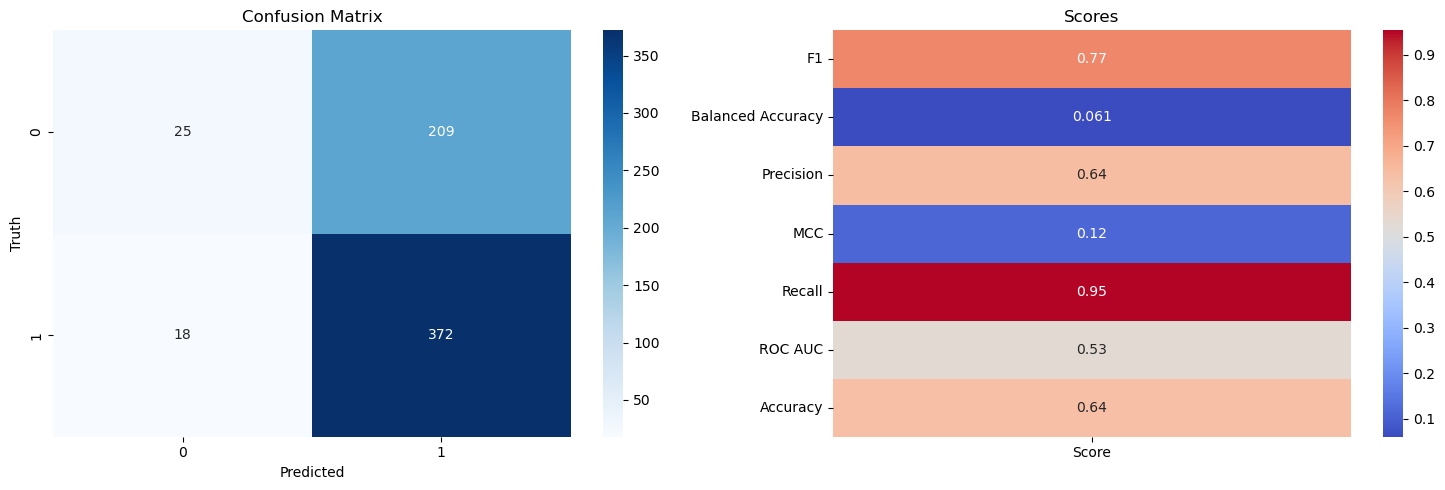

Linear Discriminant Analysis Scores:
F1: 0.7662
Balanced Accuracy: 0.0607
Precision: 0.6403
MCC: 0.1160
Recall: 0.9538
ROC AUC: 0.5303
Accuracy: 0.6362


In [32]:
# Initializing the Linear Discriminant Analysis classifier
lda = LinearDiscriminantAnalysis()

# Fitting the classifier on the training data
lda.fit(X_train_fe, y_train)

# Predicting on the test data
y_pred = lda.predict(X_test_fe)

# Evaluating the predictions and visualizing the results using the metrics function
lda_scores = metrics(y_test, y_pred)

# Printing the metrics
print("Linear Discriminant Analysis Scores:")
for metric, value in lda_scores.items():
    print(f"{metric}: {value:.4f}")

### Logistic Regression (LR) Classifier

In [33]:
# Defining the objective function for Optuna
def objective(trial):
    """
    This function uses the Optuna library for hyperparameter tuning. It defines the objective function that is used to evaluate different hyperparameters for the Logistic Regression model.
    The function suggests values for the penalty and C hyperparameters using the Optuna trial object. 
    It then initializes the Logistic Regression model with the suggested hyperparameters and fits it on the training data. 
    Finally, it predicts on the validation data and calculates the Matthews correlation coefficient (MCC) to evaluate the performance of the model.
    
    Args:
        trial (optuna.trial.Trial): The trial object for hyperparameter tuning.    
    """
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2']) # l1 lasso, l2 ridge
    C = trial.suggest_float('C', 0.001, 100.0, log=True) # inverse of regularization strength
    lr = LogisticRegression(penalty=penalty, C=C, solver='liblinear', random_state=42, class_weight=class_weights_dict) # initializing the Logistic Regression model
    
    lr.fit(X_train_fe, y_train) # fitting the model
    y_pred = lr.predict(X_val_fe) # predicting on the validation data
    mcc = matthews_corrcoef(y_val, y_pred) # computing the MCC

    return mcc # returning the MCC

# Creating Optuna study
sampler = optuna.samplers.TPESampler(multivariate=True, seed=42, warn_independent_sampling=False) # using TPESampler
pruner = optuna.pruners.HyperbandPruner() # using HyperbandPruner
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner) # creating Optuna study
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1) # optimizing the objective function

# Getting the best parameters and value
best_params = study.best_params # best parameters
best_mcc = study.best_value # best value

print("Best Parameters:", best_params)
print("Best MCC:", best_mcc)

Best trial: 45. Best value: 0.336938: 100%|██████████| 50/50 [00:01<00:00, 42.28it/s]

Best Parameters: {'penalty': 'l1', 'C': 0.00476834062094139}
Best MCC: 0.3369375259549177


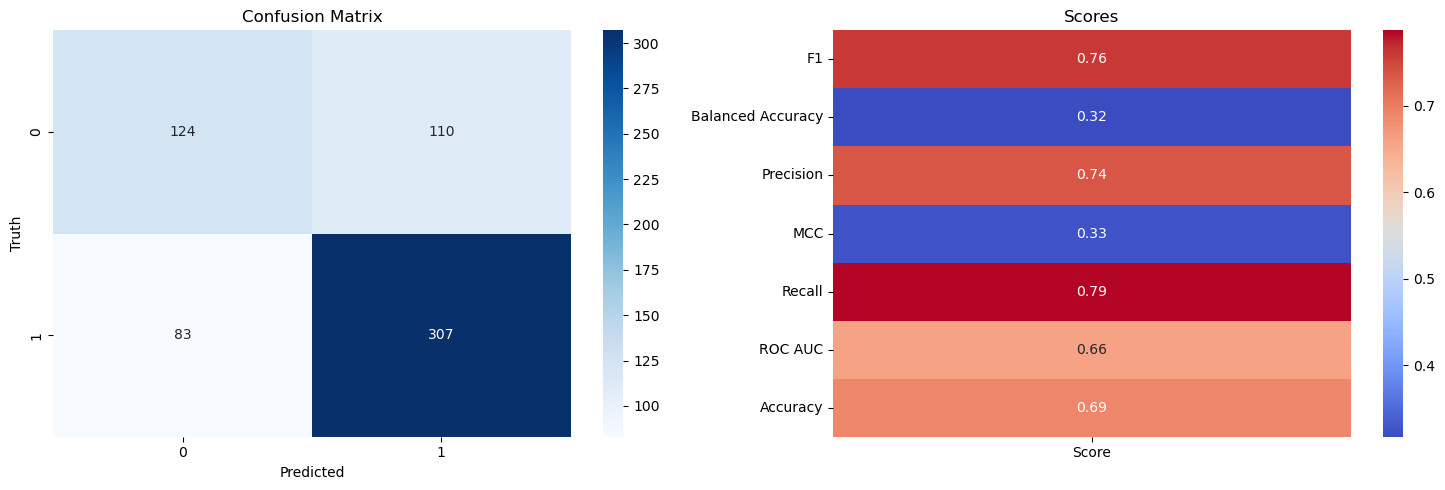

Logistic Regression Scores:
F1: 0.7608
Balanced Accuracy: 0.3171
Precision: 0.7362
MCC: 0.3260
Recall: 0.7872
ROC AUC: 0.6585
Accuracy: 0.6907


In [34]:
# Training the final Logistic Regression model with the best parameters
lr = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver='liblinear', random_state=42, class_weight=class_weights_dict)
lr.fit(X_train_fe, y_train)

# Predicting on the test data
y_pred = lr.predict(X_test_fe)

# Evaluating the predictions and visualizing the results using the metrics function
lr_scores = metrics(y_test, y_pred)

# Printing the metrics
print("Logistic Regression Scores:")
for metric, value in lr_scores.items():
    print(f"{metric}: {value:.4f}")

### Support Vector Machines (SVMs) Classifier (SVC)

In [35]:
# Defining the objective function for Optuna
def objective(trial):
    """
    This function uses the Optuna library for hyperparameter tuning. It defines the objective function that is used to evaluate different hyperparameters for the SVC model.
    The function suggests values for the 'C', 'kernel', and 'gamma' hyperparameters using the Optuna trial object. 
    It then initializes the SVC model with the suggested hyperparameters and fits it on the training data. 
    Finally, it predicts on the validation data and calculates the Matthews correlation coefficient (MCC) to evaluate the performance of the model.
    
    Args:
        trial (optuna.trial.Trial): The trial object for hyperparameter tuning.   
    """
    C = trial.suggest_float('C', 0.001, 100.0, log=True) # inverse of regularization strength
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid']) # kernel type
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel != 'linear' else 'scale' # kernel coefficient
    svm = SVC(C=C, kernel=kernel, gamma=gamma, class_weight=class_weights_dict, random_state=42) # initializing the SVC model
    
    svm.fit(X_train_fe, y_train) # fitting the model
    y_pred = svm.predict(X_val_fe) # predicting on the validation data
    mcc = matthews_corrcoef(y_val, y_pred) # computing the MCC
    return mcc

# Creating Optuna study
sampler = optuna.samplers.TPESampler(multivariate=True, seed=42, warn_independent_sampling=False) # using TPESampler
pruner = optuna.pruners.HyperbandPruner() # using HyperbandPruner
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner) # creating Optuna study
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1) # optimizing the objective function

# Getting the best parameters and value
best_params = study.best_params # best parameters
best_mcc = study.best_value # best value

print("Best Parameters:", best_params)
print("Best MCC:", best_mcc)

Best trial: 35. Best value: 0.454347: 100%|██████████| 50/50 [00:09<00:00,  5.11it/s]

Best Parameters: {'C': 9.22217094366868, 'kernel': 'rbf', 'gamma': 'scale'}
Best MCC: 0.4543472791366449


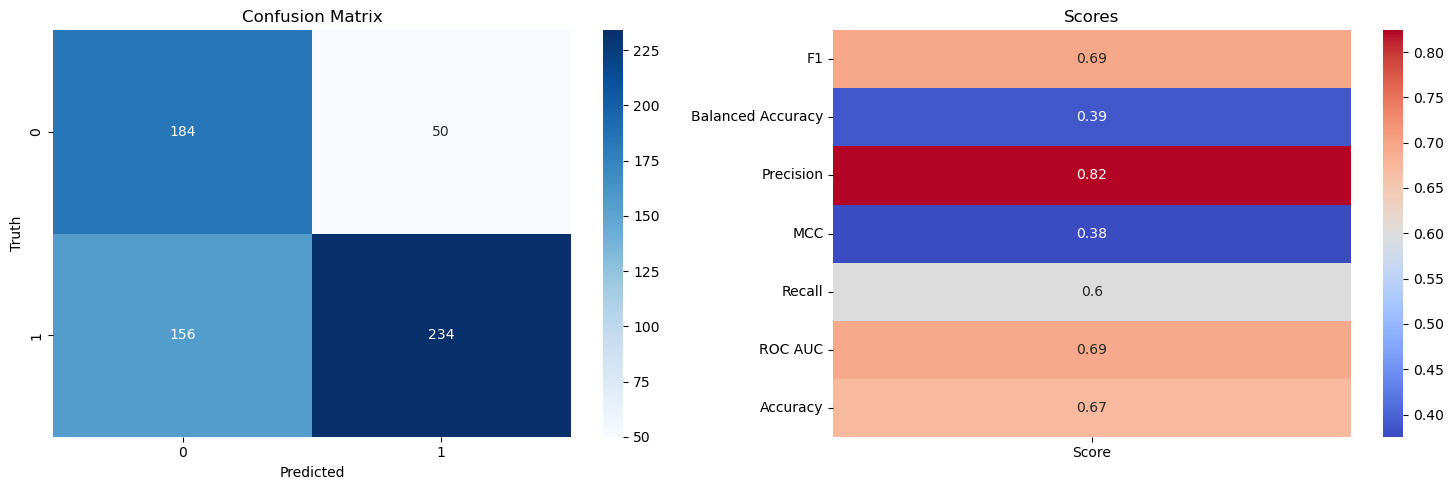

Support Vector Classifier Scores:
F1: 0.6944
Balanced Accuracy: 0.3863
Precision: 0.8239
MCC: 0.3756
Recall: 0.6000
ROC AUC: 0.6932
Accuracy: 0.6699


In [36]:
# Training the final SVM model with the best parameters
svc = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'], class_weight=class_weights_dict, random_state=42)
svc.fit(X_train_fe, y_train)

# Predicting on the test data
y_pred = svc.predict(X_test_fe)

# Evaluating the predictions and visualizing the results using the metrics function
svc_scores = metrics(y_test, y_pred)

# Printing the metrics
print("Support Vector Classifier Scores:")
for metric, value in svc_scores.items():
    print(f"{metric}: {value:.4f}")

Similarly to before, we observe that when it comes to balanced accuracy and MCC, Logistic Regression and Support Vector Machines perform significantly better compared to the baseline Gaussian Naive Bayes and Linear Discriminant Analysis classifiers. In addition, it seems that the image-specific feature extraction approach performs overall worse than the universal feature extraction with dimensionality reduction approach.

## Custom CNN Implementation with PyTorch

Our CNN implementation features a straightforward architecture:

* __Feature Extraction Base__: It includes one convolutional layer followed by max pooling. The ReLU activation function is applied to introduce non-linearity between the convolution and pooling layers.
* __MLP Head__: After flattening the extracted features, a simple network with one fully connected hidden layer is employed.
* __Batch Normalization Layers__: These are used to normalize the weights in each layer, preventing gradient explosion or vanishing and thus making the optimization of the loss function smoother and more stable.

To determine the input dimensions for the dense layer after flattening, we use the convolutional formulas.

In [17]:
class CustomCNN(nn.Module):
    def __init__(self, img_size=224, out_channels1=16, out_features=256, kernel_size_conv=3, num_classes=2):
        """
        Initializes the CustomCNN class with specified parameters and sets up the base network architecture and classifier layers.
        
        Parameters:
        - img_size (int): size of the input image (default: 224)
        - out_channels1 (int): number of output channels for the first convolutional layer (default: 16)
        - out_features (int): number of output features for the first fully connected layer (default: 256)
        - kernel_size_conv (int): size of the convolutional kernel (default: 3)
        - num_classes (int): number of output classes (default: 2)
        """
        super(CustomCNN, self).__init__() # initializing the parent class

        # Base of the network 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels1, kernel_size=kernel_size_conv, stride=1) # convolutional layer
        self.bn1 = nn.BatchNorm2d(num_features=out_channels1) # batch normalization layer
        self.relu1 = nn.ReLU() # ReLU activation layer
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # max pooling layer
        
        # Calculating the size of the flattened features after the convolutional and pooling layers
        conv_output_size = img_size - kernel_size_conv + 1 # kernel_size_conv is the size of the convolutional kernel
        maxpool_output_size = (conv_output_size // 2)  # max pooling reduces size by 2
        flatten_size = maxpool_output_size * maxpool_output_size * out_channels1 # number of features after the convolutional and pooling layers
        
        # Classifier layers
        self.flatten = nn.Flatten() # flattening the output of the convolutional and pooling layers
        self.fc1 = nn.Linear(in_features=flatten_size, out_features=out_features) # first fully connected layer
        self.bn3 = nn.BatchNorm1d(num_features=out_features) # batch normalization layer
        self.relu3 = nn.ReLU() # ReLU activation layer
        self.fc2 = nn.Linear(in_features=out_features, out_features=num_classes) # output layer
    
    # Forward pass through the network
    def forward(self, x):
        """
        A function that defines the forward pass through the network.
        
        Parameters:
        - x: input tensor
        
        Returns:
        - x: output tensor after passing through the network
        """
        x = self.conv1(x) # convolutional layer
        x = self.bn1(x) # batch normalization
        x = self.relu1(x) # relu activation function
        x = self.maxpool1(x) # max pooling
        
        x = self.flatten(x) # flattening the output of the convolutional and pooling layers
        x = self.fc1(x) # first fully connected layer
        x = self.bn3(x) # batch normalization
        x = self.relu3(x) # relu activation function
        x = self.fc2(x) # output layer

        return x # returning the output of the network

After defining the model, we need to create the training loop. This loop requires the following arguments:

1. Model architecture
2. Training data loader, responsible for loading images based on the specified batch size
3. Validation data loader
4. Class weights for adjusting the loss in cross-entropy to account for class size differences
5. Learning rate for the Adam optimizer, which controls the training speed
6. Number of epochs for training
7. Patience parameter, which sets the number of epochs the validation loss can stagnate before stopping training to avoid overfitting

Training Process (using the grayscale augmented dataset):
1. Move the batch of tensors to the GPU at the start of each epoch.
2. Use `optimizer.zero_grad()` to reset the gradients of all model parameters.
3. Calculate the model's output and the corresponding loss.
4. Perform backpropagation to update the gradients and minimize the loss.
5. Repeat steps 1-4 for each batch: load a new batch, reset gradients, calculate loss, and update gradients.

Evaluation Process (at the end of each epoch):
1. Use `torch.no_grad()` to prevent gradient updates during evaluation.
2. Feed the validation input batch from the validation loader into the model.
3. Calculate the model's output.
4. Compute the validation loss by comparing the model's output to the true target.

We maintain a copy of the best model based on the early stopping criterion, ensuring optimal performance without overfitting.

In [18]:
def train_model(model, train_loader, val_loader, class_weights_tn, learning_rate, num_epochs, patience):
    """
    Trains a given model using the provided training and validation data loaders.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): The data loader for the training data.
        val_loader (torch.utils.data.DataLoader): The data loader for the validation data.
        class_weights_tn (torch.Tensor): The class weights for the cross-entropy loss.
        learning_rate (float): The learning rate for the Adam optimizer.
        num_epochs (int): The number of epochs to train the model.
        patience (int): The number of epochs to wait for improvement in validation loss before stopping training.

    Returns:
        best_val_loss (float): The best validation loss achieved during training.
        best_model (dict): The state dict of the best model.
        train_loss_hist (List[float]): The history of training losses.
        val_loss_hist (List[float]): The history of validation losses.

    """
    train_loss_hist = [] # history of training losses
    val_loss_hist = [] # history of validation losses
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # checking if GPU is available
    class_weights_tn = class_weights_tn.float().to(device) # converting class weights to a tensor
    criterion = nn.CrossEntropyLoss(weight=class_weights_tn) # initializing the cross-entropy loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # initializing the Adam optimizer
    model.to(device) # moving model to GPU if available

    best_val_loss = float('inf') # initializing the best validation loss
    best_model = None # initializing the best model
    counter = 0 # initializing the counter for early stopping
    stop_training = False # flag for early stopping

    # Training loop
    for epoch in range(num_epochs):
        if stop_training:
            print("Early stopping. No improvement in validation loss.")
            break

        model.train() # setting the model to training mode
        running_train_loss = 0.0 # initializing the running training loss
        # Iterating over the training data
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # moving inputs and labels to GPU if available

            optimizer.zero_grad() # zeroing the gradients
            outputs = model(inputs) # making predictions
            loss = criterion(outputs, labels) # calculating the loss
            loss.backward() # backward pass
            optimizer.step() # updating the model parameters

            running_train_loss += loss.item() # adding the loss to the running training loss

        avg_train_loss = running_train_loss / len(train_loader) # calculating the average training loss
        train_loss_hist.append(avg_train_loss) # appending the training loss to the history
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

        model.eval() # setting the model to evaluation mode
        running_val_loss = 0.0 # initializing the running validation loss
        with torch.no_grad(): # disabling gradient calculation
            # Iterating over the validation data
            for inputs, labels in val_loader: 
                inputs, labels = inputs.to(device), labels.to(device) # moving inputs and labels to GPU if available
                outputs = model(inputs) # making predictions
                loss = criterion(outputs, labels) # calculating the loss
                running_val_loss += loss.item() # adding the loss to the running validation loss

        avg_val_loss = running_val_loss / len(val_loader) # calculating the average validation loss
        val_loss_hist.append(avg_val_loss) # appending the validation loss to the history
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

        # Early stopping condition for validation loss
        if avg_val_loss < best_val_loss: # checking if the validation loss is less than the best validation loss
            best_val_loss = avg_val_loss # updating the best validation loss
            counter = 0 # resetting the counter
            best_model = copy.deepcopy(model.state_dict()) # updating the best model
        else:
            counter += 1 # incrementing the counter
            if counter >= patience: # checking if the counter is greater than or equal to the patience
                stop_training = True # stopping the training

    print("Training complete!\n")
    return best_val_loss, best_model, train_loss_hist, val_loss_hist # returning the best validation loss, best model, training loss history, and validation loss history

# Converting class weights to a tensor
class_weights_tn = torch.tensor(list(class_weights_dict.values()))

# Initializing the custom CNN model
model = CustomCNN(num_classes=2)

# Setting up the DataLoader for training and validation datasets
train_loader = DataLoader(train_dataset_classic, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset_classic, batch_size=64, shuffle=False)

# Training the model
best_val_loss, trained_model, train_loss_hist, val_loss_hist = train_model(
    model, train_loader, val_loader, class_weights_tn, learning_rate=0.001, num_epochs=20, patience=5
)

# Loading the best model state
model.load_state_dict(trained_model)

print("Training complete. Best validation loss: {:.4f}".format(best_val_loss))

Epoch [1/20], Training Loss: 0.3291
Epoch [1/20], Validation Loss: 0.3191
Epoch [2/20], Training Loss: 0.1878
Epoch [2/20], Validation Loss: 0.2831
Epoch [3/20], Training Loss: 0.1571
Epoch [3/20], Validation Loss: 0.2019
Epoch [4/20], Training Loss: 0.1351
Epoch [4/20], Validation Loss: 0.1726
Epoch [5/20], Training Loss: 0.1226
Epoch [5/20], Validation Loss: 0.1888
Epoch [6/20], Training Loss: 0.1107
Epoch [6/20], Validation Loss: 0.1995
Epoch [7/20], Training Loss: 0.1031
Epoch [7/20], Validation Loss: 0.1928
Epoch [8/20], Training Loss: 0.1058
Epoch [8/20], Validation Loss: 0.1826
Epoch [9/20], Training Loss: 0.0935
Epoch [9/20], Validation Loss: 0.1788
Early stopping. No improvement in validation loss.
Training complete!

Training complete. Best validation loss: 0.1726


In [21]:
# Printing the final model summary (best weights)
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             160
       BatchNorm2d-2         [-1, 16, 222, 222]              32
              ReLU-3         [-1, 16, 222, 222]               0
         MaxPool2d-4         [-1, 16, 111, 111]               0
           Flatten-5               [-1, 197136]               0
            Linear-6                  [-1, 256]      50,467,072
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
            Linear-9                    [-1, 2]             514
Total params: 50,468,290
Trainable params: 50,468,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 21.06
Params size (MB): 192.52
Estimated Total Size (MB): 213.77
--------------------------------

We also need to define the function for making predictions, as the model outputs probabilities for each class. This process is similar to what we did for validation data in the training loop, but without the context of training epochs. We simply pass the data in batches and output the label with the highest predicted probability. Additionally, we use `torch.no_grad()` to ensure that the model's weights are not updated during this process.

In [23]:
def predict(model, test_loader):
    """
    Predicts the labels for the given images using the provided model.

    Args:
        model (torch.nn.Module): The model used for prediction.
        test_loader (torch.utils.data.DataLoader): The data loader for the test data.

    Returns:
        y_pred (List): The predicted labels for the test images.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # checking if GPU is available
    model.to(device) # moving model to GPU if available
    model.eval() # setting model to evaluation mode

    y_pred = [] # list to store predicted labels

    with torch.no_grad(): # disabling gradient calculation
        # Iterating over the test data
        for images, _ in test_loader:
            images = images.to(device) # moving images to GPU if available
            outputs = model(images) # making predictions
            _, predicted = torch.max(outputs.data, 1) # getting the predicted labels
            y_pred.extend(predicted.cpu().numpy()) # appending the predicted labels to the list
    return y_pred # returning the predicted labels

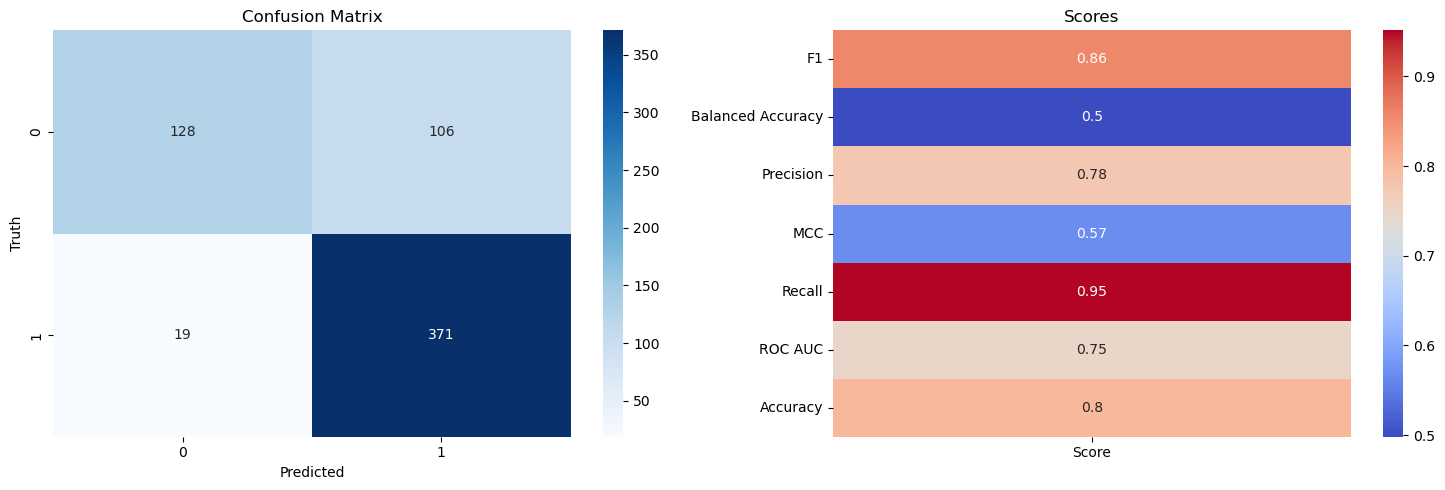

Custom CNN Scores:
F1: 0.8558
Balanced Accuracy: 0.4983
Precision: 0.7778
MCC: 0.5685
Recall: 0.9513
ROC AUC: 0.7491
Accuracy: 0.7997


In [24]:
# Setting the random seed for reproducibility
torch.manual_seed(42)

# Setting up the DataLoader for the test dataset
test_loader = DataLoader(test_dataset_classic, batch_size=256, shuffle=False)

# Predicting on the test data
y_pred = predict(model, test_loader)

# Evaluating the predictions using the metrics function
custom_cnn_score = metrics(y_test, y_pred)

# Printing the metrics
print("Custom CNN Scores:")
for metric, value in custom_cnn_score.items():
    print(f"{metric}: {value:.4f}")

## ResNet50 Pretrained CNN Model

To implement transfer learning, we replace the base of our neural network with a pre-trained model, specifically ResNet50, which has been trained on the ImageNet dataset. We freeze its weights to keep them unchanged during training. We then add a final set of layers tailored to our specific task, requiring two output classes. Only these additional layers have their weights adjusted during training.

The 50-layer ResNet architecture includes the following components:

* An initial 7×7 convolution with 64 kernels and a stride of 2.
* A max pooling layer with a stride of 2.
* Nine layers: three sets of 3×3, 64-kernel convolutions, 1×1, 64-kernel convolutions, and 1×1, 256-kernel convolutions, repeated three times.
* Twelve layers: three sets of 1×1, 128-kernel convolutions, 3×3, 128-kernel convolutions, and 1×1, 512-kernel convolutions, repeated four times.
* Eighteen layers: three sets of 1×1, 256-kernel convolutions, 3×3, 256-kernel convolutions, and 1×1, 1024-kernel convolutions, repeated six times.
* Nine layers: three sets of 1×1, 512-kernel convolutions, 3×3, 512-kernel convolutions, and 1×1, 2048-kernel convolutions, repeated three times.
* An average pooling layer, followed by a fully connected layer with 1000 nodes using the softmax activation function.

In [26]:
# Define the custom ResNet model
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        """
        Initializes the CustomResNet model with a given number of classes.

        Args:
            num_classes (int): The number of classes for the final layer.
        """
        super(CustomResNet, self).__init__()

        # Loading the pretrained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)

        # Freezing the pre-trained layers
        for param in self.resnet.parameters(): # iterating over the parameters of the model
            param.requires_grad = False # freezing the parameters

        num_ftrs = self.resnet.fc.in_features # number of features in the final layer
        self.resnet.fc = nn.Linear(num_ftrs, num_classes) # replacing the final layer

    def forward(self, x):
        """
        A method that defines the forward pass of the CustomResNet model.

        Args:
            x (torch.Tensor): The input tensor to the model.

        Returns:
            x (torch.Tensor): The output tensor after passing through the ResNet model.
        """
        x = self.resnet(x) # passing the input tensor through the ResNet model
        return x # returning the output

# Initializing the custom ResNet model
model = CustomResNet(num_classes=2)

# Setting up the DataLoader for training and validation datasets
train_loader = DataLoader(train_dataset_pretrained, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset_pretrained, batch_size=64, shuffle=False)

# Training the model
best_val_loss, trained_model, train_loss_hist, val_loss_hist = train_model(
    model, train_loader, val_loader, class_weights_tn, learning_rate=0.001, num_epochs=20, patience=5
)

# Loading the best model state
model.load_state_dict(trained_model)

print("Training complete. Best validation loss: {:.4f}".format(best_val_loss))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/giatraskon/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:56<00:00, 1.82MB/s]


Epoch [1/20], Training Loss: 0.3959
Epoch [1/20], Validation Loss: 0.2952
Epoch [2/20], Training Loss: 0.2394
Epoch [2/20], Validation Loss: 0.2657
Epoch [3/20], Training Loss: 0.2193
Epoch [3/20], Validation Loss: 0.2314
Epoch [4/20], Training Loss: 0.1952
Epoch [4/20], Validation Loss: 0.2454
Epoch [5/20], Training Loss: 0.2036
Epoch [5/20], Validation Loss: 0.2872
Epoch [6/20], Training Loss: 0.1958
Epoch [6/20], Validation Loss: 0.2068
Epoch [7/20], Training Loss: 0.1982
Epoch [7/20], Validation Loss: 0.2025
Epoch [8/20], Training Loss: 0.2227
Epoch [8/20], Validation Loss: 0.2092
Epoch [9/20], Training Loss: 0.1876
Epoch [9/20], Validation Loss: 0.1875
Epoch [10/20], Training Loss: 0.1892
Epoch [10/20], Validation Loss: 0.2616
Epoch [11/20], Training Loss: 0.2017
Epoch [11/20], Validation Loss: 0.2329
Epoch [12/20], Training Loss: 0.1862
Epoch [12/20], Validation Loss: 0.2922
Epoch [13/20], Training Loss: 0.1887
Epoch [13/20], Validation Loss: 0.2120
Epoch [14/20], Training Loss: 

In [27]:
# Printing the final model summary (best weights)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Setting the random seed for reproducibility
torch.manual_seed(42)

# Setting up the DataLoader for the test dataset
test_loader = DataLoader(test_dataset_pretrained, batch_size=256, shuffle=False)

# Predicting on the test data
y_pred = predict(model, test_loader)

# Evaluating the predictions using the metrics function
pretrained_cnn_score = metrics(y_test, y_pred)

# Printing the metrics
print("Pretrained ResNet Scores:")
for metric, value in pretrained_cnn_score.items():
    print(f"{metric}: {value:.4f}")

# <ins>Results and Discussion</ins>

## Results Summary

__Classical Machine Learning with Universal Feature Extraction Using Dimensionality Reduction__:

* __Gaussian Naive Bayes__: MCC: 0.3840, Balanced Accuracy: 0.3752
* __Linear Discriminant Analysis__: MCC: 0.4776, Balanced Accuracy: 0.4308
* __Logistic Regression__: MCC: 0.5822, Balanced Accuracy: 0.5641
* __Support Vector Classifier__: MCC: 0.5868, Balanced Accuracy: 0.5325

__Classical Machine Learning with Image-Specific Feature Extraction__:

* __Gaussian Naive Bayes__: MCC: 0.0418, Balanced Accuracy: 0.0077
* __Linear Discriminant Analysis__: MCC: 0.1160, Balanced Accuracy: 0.0607
* __Logistic Regression__: MCC: 0.3260, Balanced Accuracy: 0.3171
* __Support Vector Classifier__: MCC: 0.3756, Balanced Accuracy: 0.3863

__Custom CNN Implementation with PyTorch__: MCC: 0.5685, Balanced Accuracy: 0.4983

## Discussion

The universal feature extraction strategy consistently outperformed the image-specific feature extraction approach, particularly with the Logistic Regression achieving the close second highest MCC (0.5822) and highest balanced accuracy (0.5641). The image-specific feature extraction approach yielded poor results across all classifiers, with significantly lower MCC and balanced accuracy scores, indicating that crucial information may have been lost during preprocessing.

The custom CNN implementation demonstrated competitive performance with an MCC of 0.5685 and a balanced accuracy of 0.4983 (slightly below the universal feature extraction Linear Regression model, but still notable). However, due to the parameter trade-offs and time constraints, the pretrained ResNet-50 results were not considered in this comparison.

Overall, while the traditional Logistic Regression approach with dimensionality reduction was highly effective, the custom CNN showed potential, suggesting that further tuning and optimization could lead to even better performance.